In [6]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd
import re

# set font size to all plots to 18
plt.rcParams.update({"font.size": 18})

In [7]:
FILE = "../data/append_tik_tok_analysis_v2.xlsx"

df_tk = pd.read_excel(FILE)

df_tk = df_tk.drop_duplicates(subset="link")

df_tk["scrapped_comments"] = df_tk["comments_text"].apply(
    lambda x: len(str(x).split("|"))
)
total_comments = df_tk["scrapped_comments"].sum()
print(f"Total comments: {total_comments}")

Total comments: 26244


In [8]:
first_date = df_tk["date_parsed"].min()
last_date = df_tk["date_parsed"].max()

print(f"First date: {first_date} | Last date: {last_date}")

First date: 2020-12-12 00:00:00 | Last date: 2025-03-01 00:00:00


In [142]:
stop_words = set(stopwords.words("spanish"))
stop_words.add("-")
stop_words.add("|")

for w in [
    "hacer",
    "puede",
    "puedo",
    "quiero",
    "siempre",
    "así",
    "solo",
    "0993447612ambato",
    "0989471791portoviejo",
    "0993993296uio",
    "0991584023manta",
    "0997484509provincia",
    "0997478450provincia",
    "0968923496uio",
    "0993999296uio",
]:
    stop_words.add(w)

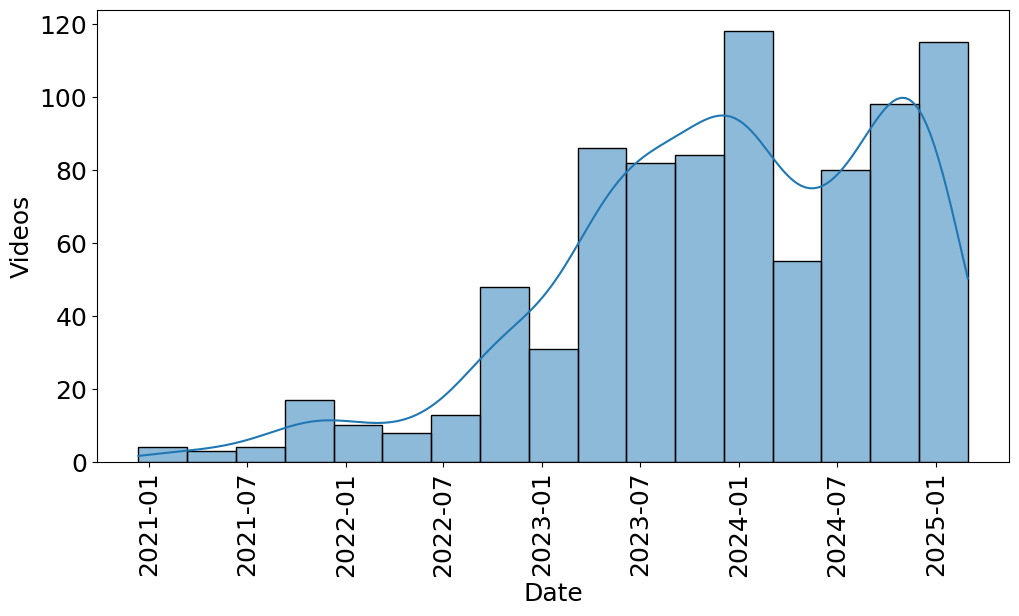

In [91]:
# plot gauss distribution of dates
sns.histplot(df_tk["date_parsed"], kde=True)
plt.tight_layout()
plt.gcf().set_size_inches(12, 6)
plt.xlabel("Date")
plt.ylabel("Videos")
plt.xticks(rotation=90)
# rotate x labels
plt.savefig("../imgs/tik_tok_dates.png", dpi=300)

'\nRangos/Picos:\n1: 2022-09 -> 2022-11\n2: 2023-01 -> 2023-03\n3: 2023-05 -> 2023-09\n4: 2023-11 -> 2024-01\n5: 2024-01 (Fito mi primo)\n6: 2024-03 -> 2024-04\n7: 2024-06 -> 2024-08\n8: 2024-11 -> 2024-12\n'

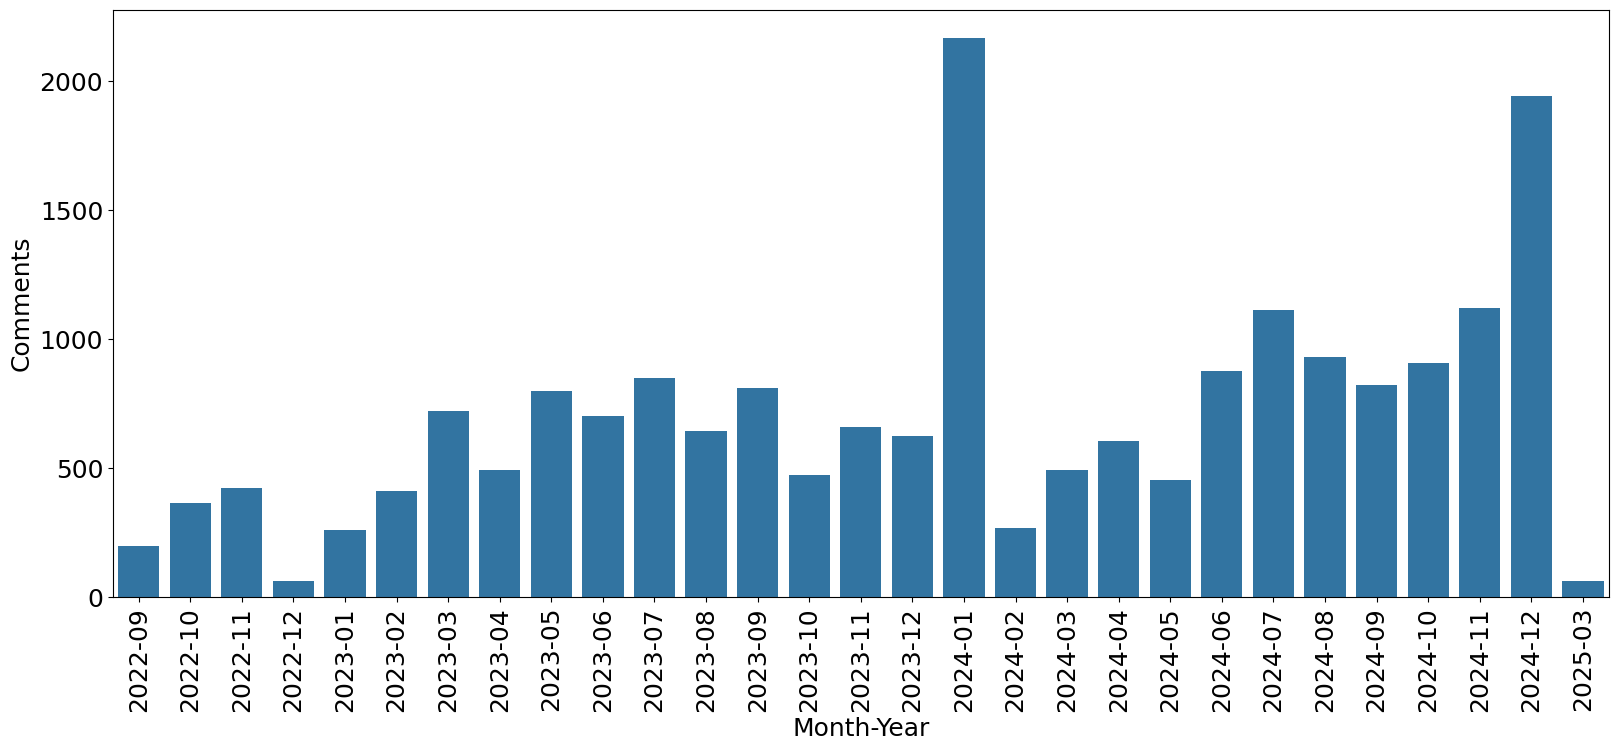

In [33]:
df_tk["month-year"] = df_tk["date_parsed"].dt.to_period("M")
df_group_month = (
    df_tk.groupby("month-year").agg({"scrapped_comments": "sum"}).reset_index()
)
df_group_month = df_group_month[df_group_month["month-year"] != "2025-01"]

sns.barplot(
    x="month-year",
    y="scrapped_comments",
    data=df_group_month[df_group_month["month-year"] >= "2022-09"],
)
plt.xticks(rotation=90)
plt.tight_layout()
plt.gcf().set_size_inches(20, 10)
plt.xlabel("Month-Year")
plt.ylabel("Comments")
plt.savefig("../imgs/tik_tok_month_year.png", dpi=300)
"""
Rangos/Picos:
1: 2022-09 -> 2022-11
2: 2023-01 -> 2023-03
3: 2023-05 -> 2023-09
4: 2023-11 -> 2024-01
5: 2024-01 (Fito mi primo)
6: 2024-03 -> 2024-04
7: 2024-06 -> 2024-08
8: 2024-11 -> 2024-12
"""

In [165]:
from typing import List


def print_plot(
    _df, target_months: List[str], min_length_word: int = 4, num_bar: int = 60
):

    print(f"-" * 50)

    target_months = [pd.Period(month) for month in target_months]

    # create plt subplots, description on left and comments on right

    # fig, axs = plt.subplots(1, 2, figsize=(30, 8))

    for idx, target_columns in enumerate(["description", "comments_text"]):

        _df[target_columns] = _df[target_columns].apply(lambda x: str(x).lower())

        def _check_stop_words(words: str) -> bool:
            word_list = words.split()

            words_allowed = []

            for word in word_list:
                word = re.sub(r"[^\w\s]", "", word).strip().lower()
                if word == "tc":
                    words_allowed.append(word)
                if (
                    word not in stop_words
                    and len(word) > min_length_word
                    and not word.startswith("@")
                ):
                    words_allowed.append(word)

            return " ".join(words_allowed)

        _df[target_columns] = _df[target_columns].apply(lambda x: _check_stop_words(x))

        _df["month-year"] = _df["date_parsed"].dt.to_period("M")

        target = _df[_df["month-year"].isin(target_months)]
        print(f"Total rows: {len(target)}")

        df_group_comments = (

            _df.groupby("month-year").agg({target_columns: " ".join}).reset_index()
        )


        words = df_group_comments[df_group_comments["month-year"].isin(target_months)][
            target_columns
        ]

        words_rows = []

        for row in words:
            words_rows.extend(row.split())

        print(f"Total words: {len(words_rows)}")

        dict_words = {}

        for word in words_rows:

            word = re.sub(r"[^\w\s]", "", word).strip()

            if word not in dict_words:

                dict_words[word] = 1

            else:

                dict_words[word] += 1

        print(
            f"Words of {len(dict_words)}",
            "0993993296uio" in dict_words.keys(),
            dict_words.keys(),
        )


        df_words = pd.DataFrame(dict_words.items(), columns=["word", "count"])

        df_words = df_words.sort_values(by="count", ascending=False)

        df_words = df_words.head(num_bar)

        fig = sns.barplot(data=df_words, x="word", y="count")

        plt.gcf().set_size_inches(16, 5)

        plt.xlabel("Word")
        plt.title(
            "Description of Tik Tok"
            if target_columns == "description"
            else "Comments of Tik Tok"
        )
        #  set x label to Word

        # tight layout
        plt.tight_layout()

        #  plt.xticks(rotation=90)
        fig.set_xticklabels(fig.get_xticklabels(), rotation=90)

        fig.set(ylabel="Count")

        print(f"Plotting {target_columns} of {target_months}")

        # wordcloud = WordCloud(
        #     width=800, height=400, background_color="white"
        # ).generate_from_frequencies(dict_words)

        # plt.figure(figsize=(12, 6))

        # plt.imshow(wordcloud, interpolation="bilinear")

        # plt.axis("off")

        # print(f"Wordcloud of {target_columns} of {target_months}")
        plt.savefig(f"../imgs/tik_tok_{target_columns}_{target_months}.png", dpi=300)

        plt.show()

    # plt.show()

--------------------------------------------------
Total rows: 50
Total words: 211
Words of 179 False dict_keys(['lasso', 'fiesta', 'penitenciaria', 'litoral', 'vizuete', 'noticias', 'tiguerones', 'andamos', 'rulay', 'maquinon', 'conveniente', 'cárcel', 'coordinar', 'gobierno', 'lucha', 'delincuencia', 'socio', 'vivienda', 'insolito', 'plena', 'transmision', 'ladrones', 'intentan', 'robar', 'periodista', 'ecuador', 'vanesa', 'robles', 'perteneciente', 'cadena', 'television', 'ecuatoriana', 'teleamazonas', 'encontraba', 'cubriendo', 'enlace', 'amenazada', 'integridad', 'física', 'octubre', 'balacera', 'semana', 'asesinaron', 'personas', 'alías', 'morsa', 'líder', 'organización', 'criminal', 'menor', 'exactamente', 'abatió', 'roger', 'llerena', 'contaba', 'varios', 'procesos', 'tráfico', 'drogas', 'tenencias', 'armas', 'confirmó', 'menos', 'cinco', 'fallecidos', 'recientes', 'enfrentamientos', 'penitenciaría', 'cárceles', 'guayaquil', 'presidente', '100minutos', 'solución', 'durán', 'sig

C:\Users\emman\AppData\Local\Temp\ipykernel_2212\491521333.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90)


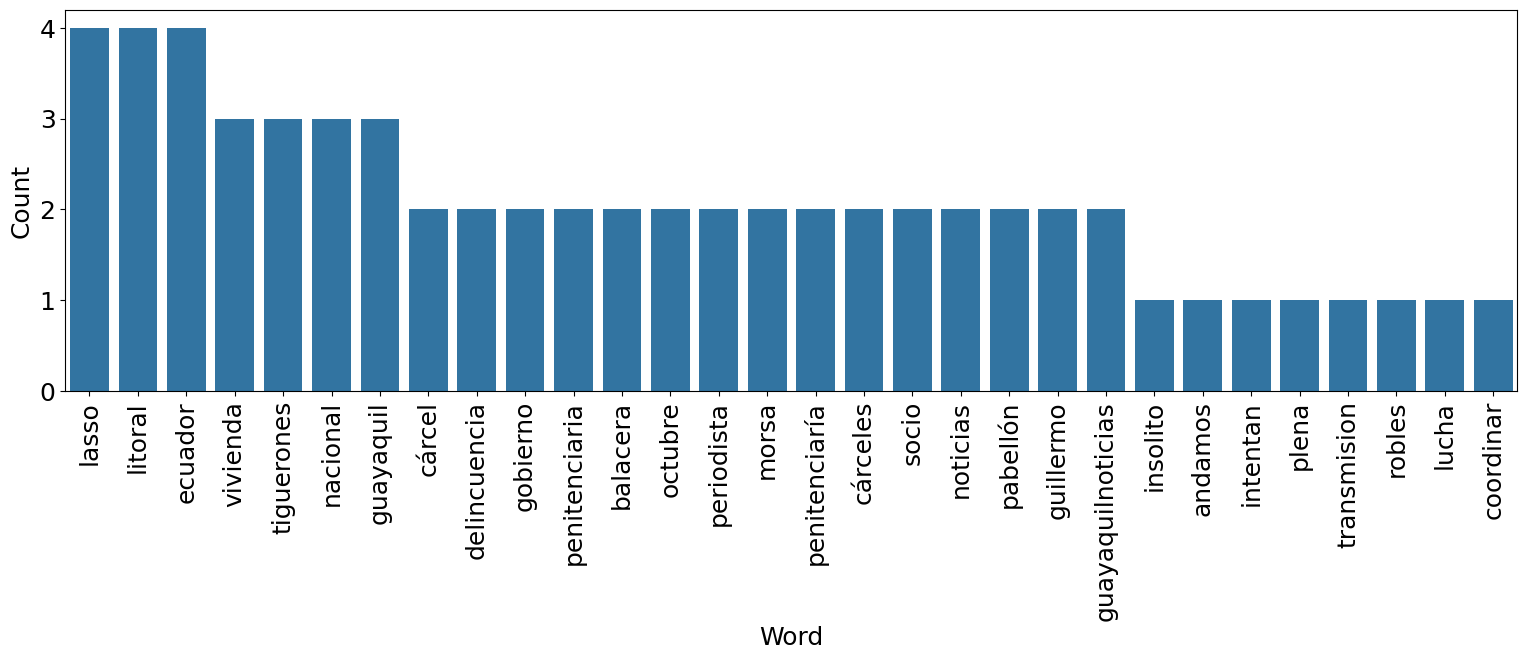

Total rows: 50
Total words: 3065
Words of 1950 False dict_keys(['marchar', 'población', 'exigiendo', 'seguridad', 'ejército', 'calles', 'siento', 'vacunas', 'beneficiando', 'gobierno', 'nadala', 'única', 'forma', 'combatir', 'fuego', 'policía', 'presidentcnn', 'hecho', 'mismo', 'secreto', 'crear', 'cuarentena', 'miedo', 'volver', 'quebrar', 'negocios', 'economíalamentablemente', 'cerrar', 'negocio', 'estimado', 'maldad', 'humano', 'triplicado', 'busquemos', 'autoridades', 'yegan', 'recojer', 'muertolas', 'hacen', 'mafias', 'pasan', 'billetequerían', 'banquero', 'corrupto', 'antecedentes', 'feriado', 'bancario', 'presidente', 'tomen', 'maduropaso', 'hermano', 'norte', 'fuetodos', 'calmemos', 'diosel', 'dueño', 'mundolo', 'peorpoquitos', 'cabrea', 'esque', 'invitanel', 'ecuador', 'encuentroy', 'falta', 'digan', 'lafarra', 'correayo', 'queriendo', 'cumpleaños', 'camaretaeso', 'salvador', 'sucede', 'chiste', 'señores', 'encuentrosi', 'quiera', 'fiestas', 'permiso', 'siquiera', 'vacaciones'

C:\Users\emman\AppData\Local\Temp\ipykernel_2212\491521333.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90)


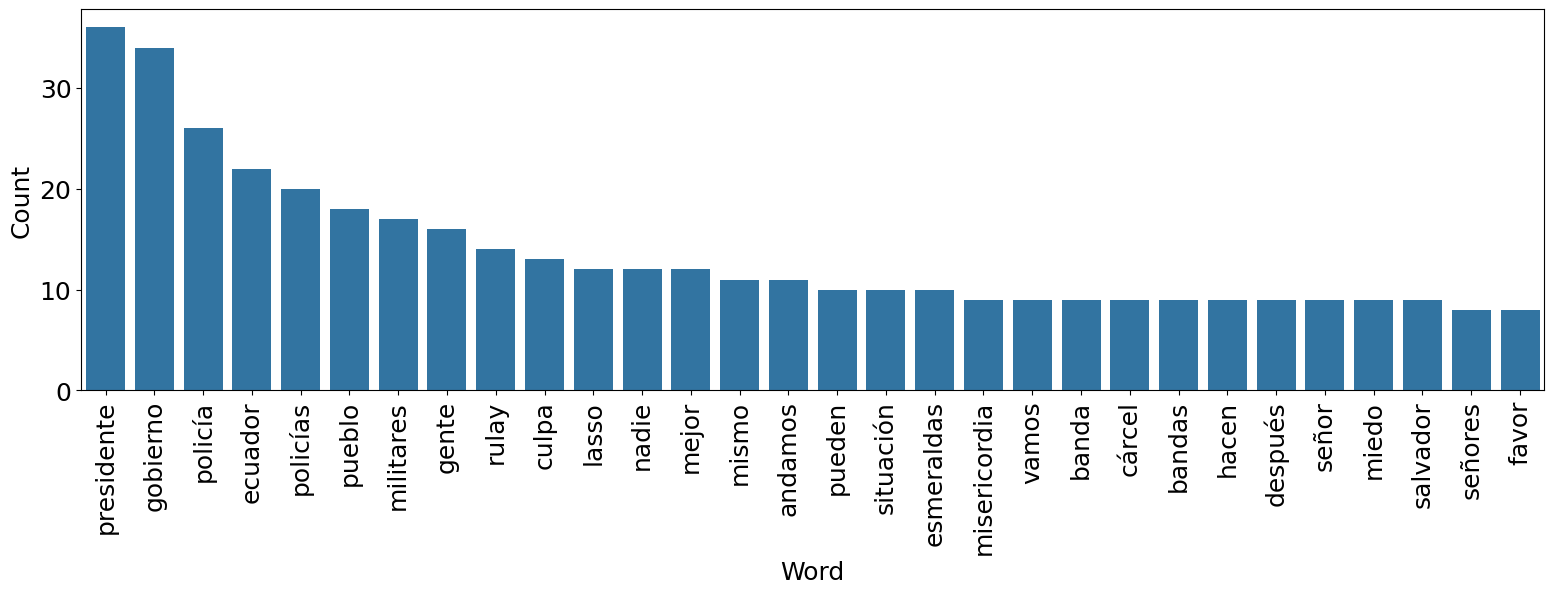

--------------------------------------------------
Total rows: 82
Total words: 761
Words of 556 False dict_keys(['seguimiento', 'vehículo', 'interceptado', 'agentes', 'procedieron', 'detenerlos', 'investigaciones', 'película', 'mañana', 'miércoles', 'enero', 'policías', 'percataron', 'cooperativa', 'gallegos', 'iniciando', 'persecución', 'pillos', 'tomaron', 'perimetral', 'impactaron', 'poste', 'alumbrado', 'público', 'detalles', 'extraec', 'toque', 'queda', 'sujetos', 'robaron', 'gasolinera', 'autopista', 'narcisa', 'jesús', 'guayaquil', 'madrugada', 'sitio', 'bazán', 'amplía', 'cacheros', 'billetes', 'jajajaaa', 'encapuchados', 'toman', 'canal', 'televisión', 'ecuador', 'martes', 'diferentes', 'ataques', 'registrados', 'televisora', 'ingresaron', 'sometiendo', 'personal', 'transmisión', 'individuos', 'exigieron', 'empleados', 'solicitaran', 'directo', 'policía', 'retirara', 'lugar', 'señal', 'suspendida', 'estableció', 'cerco', 'alrededor', 'estación', 'sucesos', 'similares', 'ocurri

C:\Users\emman\AppData\Local\Temp\ipykernel_2212\491521333.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90)


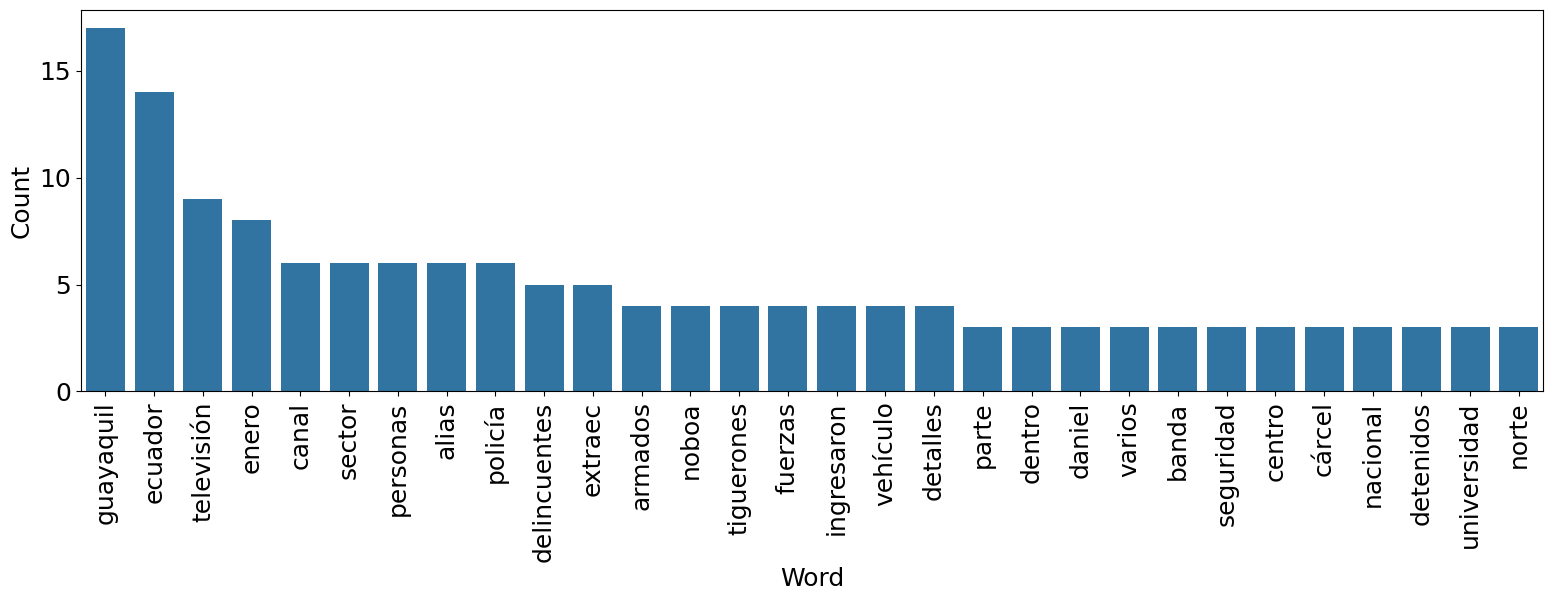

Total rows: 82
Total words: 5821
Words of 3493 False dict_keys(['tricimotos', 'placas', 'numerosen', 'sauces', 'iglesia', 'camaras', 'municipio', 'robos', 'accesorios', 'sabemos', 'activas', 'cámarasal', '911biennnnsigan', 'redes', 'sociales', 'instagram', 'revolucionario_rc5facebook', 'revolucionariorc5y', 'fenix', 'soltaron', 'denuncia', 'fugaeso', 'todas', 'horasnada', 'llama', 'aparece', 'soltarlospero', 'debería', 'tricimoto', 'nuevo', 'norte', 'ninguna', 'tienetodo', '5exelemteexcelente', 'servicio', 'segura', 'guayaquil', 'fortalece', 'seguridad', 'ciudadanaojalá', 'saquen', 'vídeos', 'integral', 'actual', 'administración', 'revolución', 'posyel', '911deberian', 'administrar', 'militaresxq', 'llaman', 'emergencia', 'llegan', 'nuncamejor', 'darle', 'aquien', 'trabaj', 'seguridadesa', 'manera', 'correcta', 'coordinar', 'cámaras', 'policía', 'nacionaly', 'dañadas', 'servian', 'habia', 'dinero', 'invertido', 'ahora', 'sacan', 'videos', 'quehay', 'amariilla', 'ygual', 'carpas', 'anda

C:\Users\emman\AppData\Local\Temp\ipykernel_2212\491521333.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90)


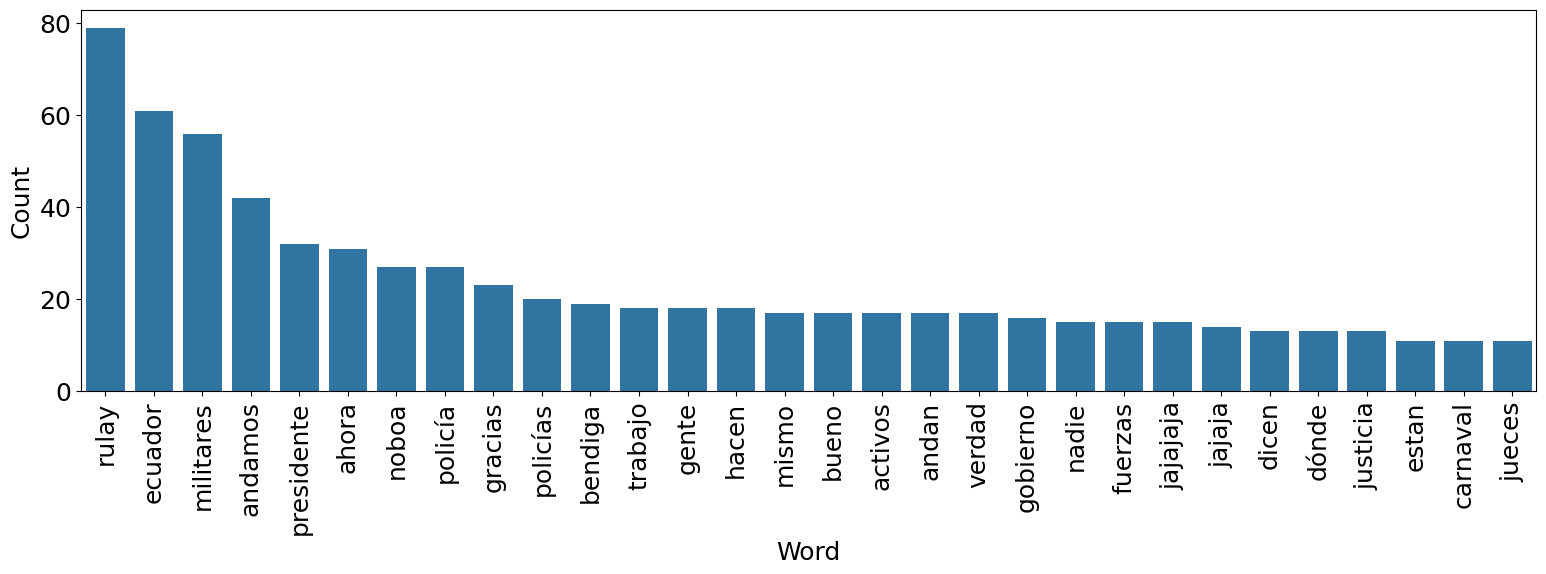

--------------------------------------------------
Total rows: 34
Total words: 336
Words of 273 False dict_keys(['muertos', 'varios', 'heridos', 'masacre', 'registrada', 'cooperativa', 'mariuxi', 'febres', 'cordero', 'guasmo', 'secuestros', 'extorsiones', 'incrementado', 'comprende', 'guayaquil', 'duran', 'samborondón', 'casuarina', 'encargado', 'recicladora', 'intentaron', 'secuestrarlo', 'arellano', 'cabecilla', 'grupo', 'criminal', 'águilas', 'recibido', 'fuegos', 'pirotécnicos', 'milagro', 'pasado', 'marzo', 'concediera', 'cumpla', 'régimen', 'semiabiertonoticicas', 'ciudadanos', 'denunciaron', 'presencia', 'sujetos', 'extorsionaban', 'suburbio', 'ciudad', 'calle', 'portete', 'segura', 'activó', 'sistema', 'videovigilancia', 'localizar', 'vehículo', 'notificó', 'sospechosos', 'percatarse', 'policía', 'escapar', 'interceptados', 'detenidos', 'investigaciones', 'reciente', 'grabado', 'regional', 'transmite', 'cárcel', 'vizuete', 'disturbios', 'ocurridos', 'noche', 'miércoles', 'dejar

C:\Users\emman\AppData\Local\Temp\ipykernel_2212\491521333.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90)


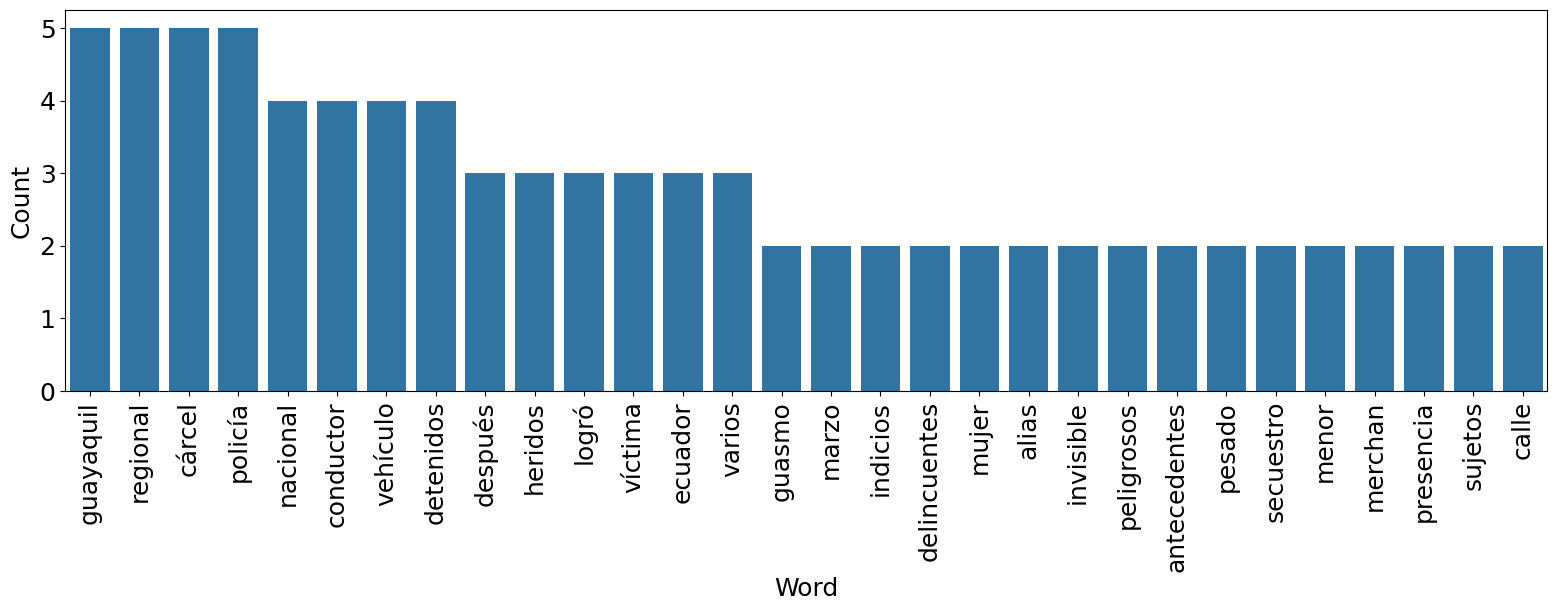

Total rows: 34
Total words: 3253
Words of 2126 False dict_keys(['militares', 'suban', 'entiende', 'necesitamos', 'dinero', 'sustentarnos', 'hicieron', 'juramento', 'proteger', 'pueblo', 'ecuatorianogracias', 'presidentecuando', 'estocuando', 'esodigan', 'fecha', 'grabacionque', 'adivinanzala', 'corte', 'constitucional', 'enemigo', 'camellar', 'fuerza', 'públicaeste', 'nuevo', 'ecuador', 'decía', 'diana', 'jácome', 'podíamos', 'salir', 'casas', 'pasaba', 'trabajos', 'seguridad', 'ecuadorcuando', 'amenasanya', 'meses', 'gastoque', 'pasandodios', 'pasandoa', 'esoesto', 'simple', 'entender', 'bandas', 'matando', 'triste', 'aunque', 'saben', 'entran', 'negocios', 'sucios', 'tbarriesgan', 'chuch', 'dicen', 'fuees', 'verdad', 'tiempo', 'patrullan', 'hacían', 'atrás', 'calmo', 'bastante', 'muertes', 'ahora', 'control', 'hmillón', 'veces', 'sitodo', 'consultaapoyo', 'total', 'noboanoboa', 'presidente', '2025pá', 'supuesto', 'fénix', 'nobita', 'consultala', 'palabra', 'hombre', 'firma', 'novoa',

C:\Users\emman\AppData\Local\Temp\ipykernel_2212\491521333.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90)


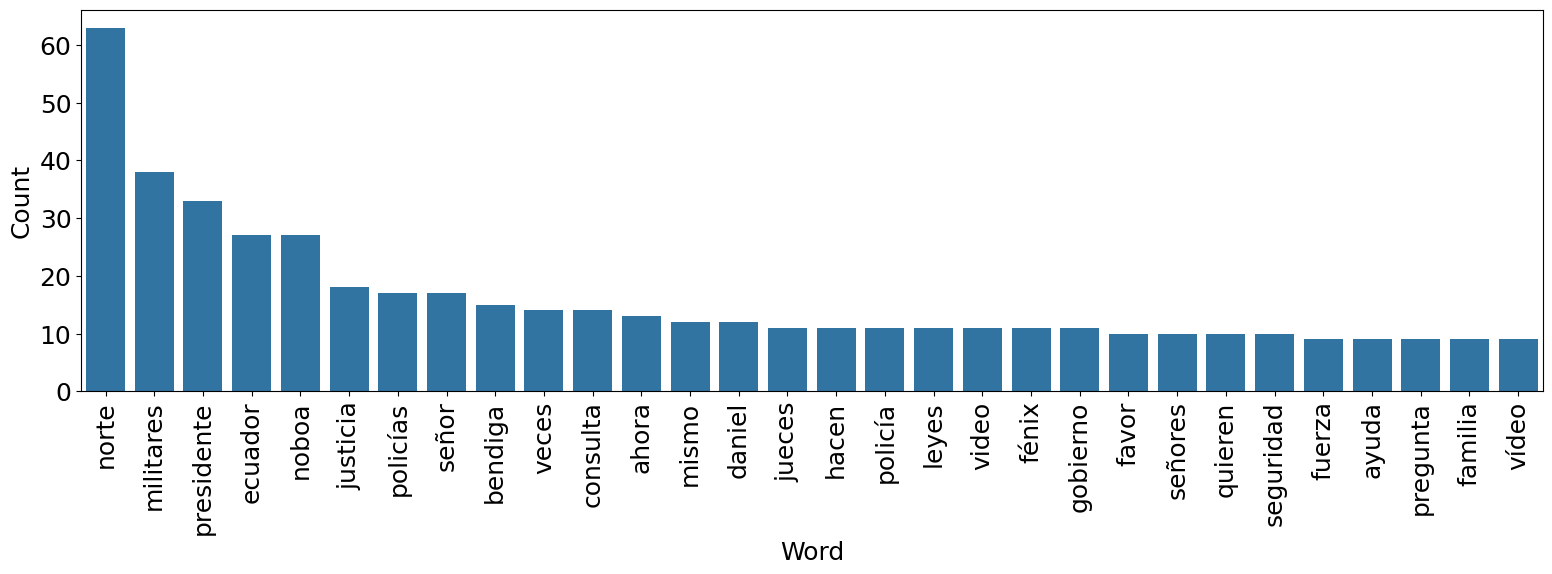

--------------------------------------------------
Total rows: 81
Total words: 1270
Words of 860 False dict_keys(['asadero', 'pollo', 'amanece', 'convertido', 'velación', 'antisociales', 'ingresaron', 'local', 'robaron', 'comensales', 'propietario', 'decide', 'enfrentar', 'delincuentes', 'propina', 'disparo', 'acabó', 'ocurrió', 'daule', 'norte', 'guayaquil', 'mañana', 'martes', 'junio', 'policía', 'servicio', 'activo', 'herido', 'cinco', 'llegaron', 'bordo', 'tricimoto', 'hecho', 'ciudadela', 'periodista', 'uniformado', 'custodia', 'fiscal', 'amplía', 'extraec', 'madrugada', 'sectores', 'altamente', 'inseguros', 'intervenidos', 'policia', 'operativo', 'resurgir', 'participaron', 'policias', 'diferentes', 'unidades', 'especializadas', 'casas', 'tomadas', 'bandas', 'delictivas', 'recuperadas', 'entregadas', 'propietarios', 'habian', 'desplazados', 'ademas', 'detenidos', 'chozas', 'destruidas', 'alerta', 'persona', 'resultado', 'herida', 'luego', 'tiroteo', 'registró', 'afueras', 'hospit

C:\Users\emman\AppData\Local\Temp\ipykernel_2212\491521333.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90)


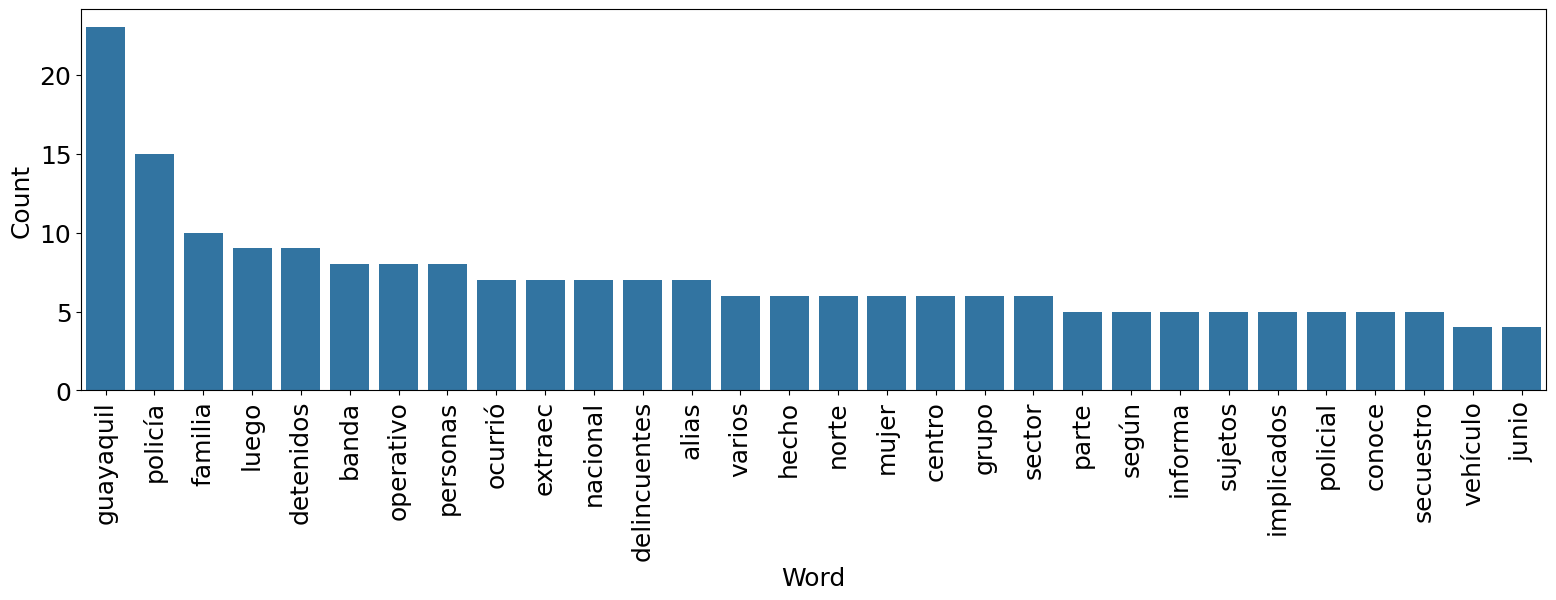

Total rows: 81
Total words: 10796
Words of 5562 False dict_keys(['nobita', 'segurotan', 'suceda', 'cantidad', 'militares', 'encuentran', 'desplegados', 'después', 'incremento', 'consulta', 'popularya', 'apoyaste', 'novoa', 'queen', 'ecuador', 'presi', 'disminuyendo', 'muertes', 'delincuenciadicen', 'mejor', 'presidentearriba', 'novita', 'favor', 'desismormar', 'contacto', 'corresistagracias', 'noboaya', 'historia', 'presidente', 'pronuncia', 'resguardada', 'ciudadanía', 'interesaeso', 'feliz', 'contento', 'novoay', 'estopero', 'ministra', 'contrario', 'desgrpero', 'plata', 'colocar', 'camaras', 'sacarle', 'puebloy', 'fénixahora', 'diran', 'canal', 'correístal', 'segunda', 'fénix', 'matar', 'gente', 'trabajadoraq', 'bárbaro', 'noboa', 'pasando', 'quedo', 'grande', 'paísque', 'uniformado', 'policía', 'metropolitano', 'ctecarguen', 'armas', 'ayuden', 'vivir', 'exigen', 'impuestoel', 'nuevo', 'florindos', 'felicesel', 'avanzaes', 'parte', 'seguir', 'apoyando', 'políticos', 'solución', 'pro

C:\Users\emman\AppData\Local\Temp\ipykernel_2212\491521333.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90)


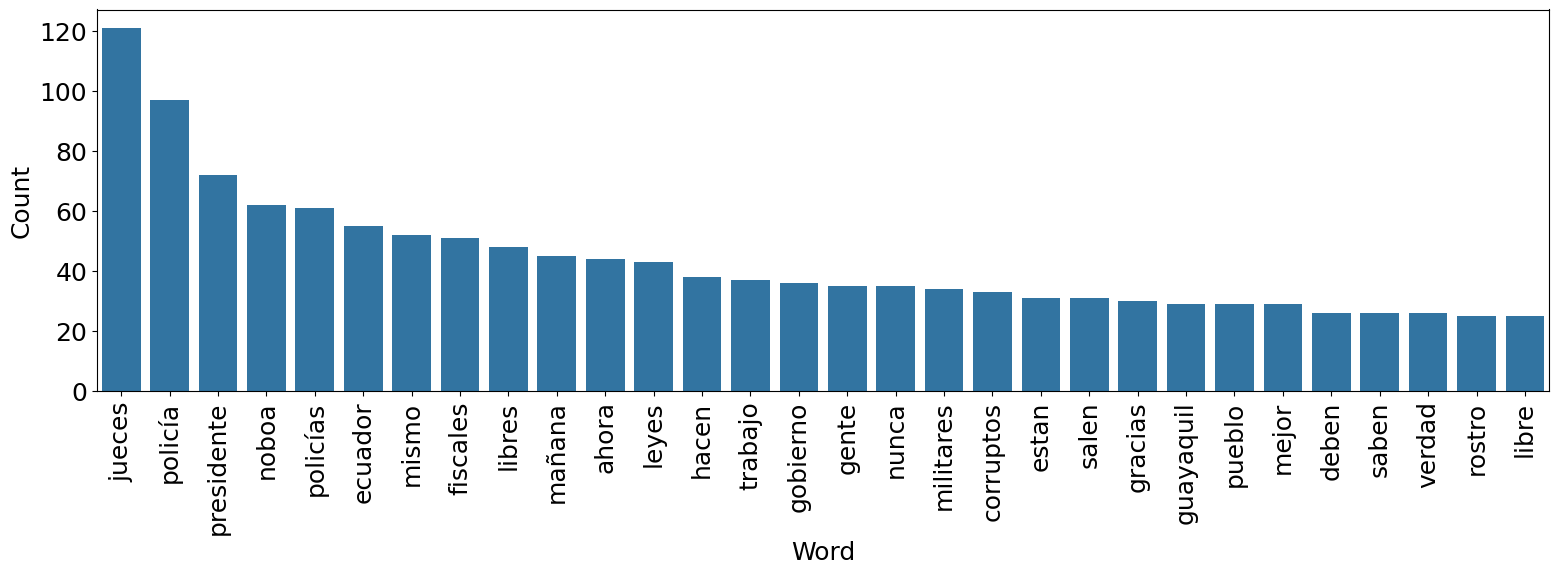

--------------------------------------------------
Total rows: 110
Total words: 1382
Words of 885 False dict_keys(['menor', 'asesinado', 'lunes', 'noviembre', 'frente', 'unidad', 'educativa', 'guayaquil', 'cheme', 'guayakill', 'ladrones', 'varios', 'inmuebles', 'allanados', 'miembros', 'águilas', 'latin', 'aprehendidos', 'sector', 'florida', 'maykel', 'david', 'alias', 'terry', 'fernando', 'chino', 'efraín', 'alexander', 'allan', 'daniel', 'michael', 'ronald', 'pelón', '4ntecedentes', 'auspiciado', 'universidad', 'bolivariana', 'ecuador', 'suscríbete', 'canal', 'youtube', 'httpn9cl6l43r', 'policía', 'investiga', 'secuestro', 'empresario', 'criminales', 'asesinaron', 'acompañante', 'tiros', 'maría', 'gabriela', 'carpio', 'reporte', 'detalles', 'ecuavisacom', 'nacional', 'desarticula', 'banda', 'venezolanos', 'involucrados', 'múltiples', 'delitos', 'operativo', 'exitoso', 'logró', 'desmantelar', 'organización', 'criminal', 'compuesta', 'ciudadanos', 'operación', 'encontraron', 'posesión'

C:\Users\emman\AppData\Local\Temp\ipykernel_2212\491521333.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90)


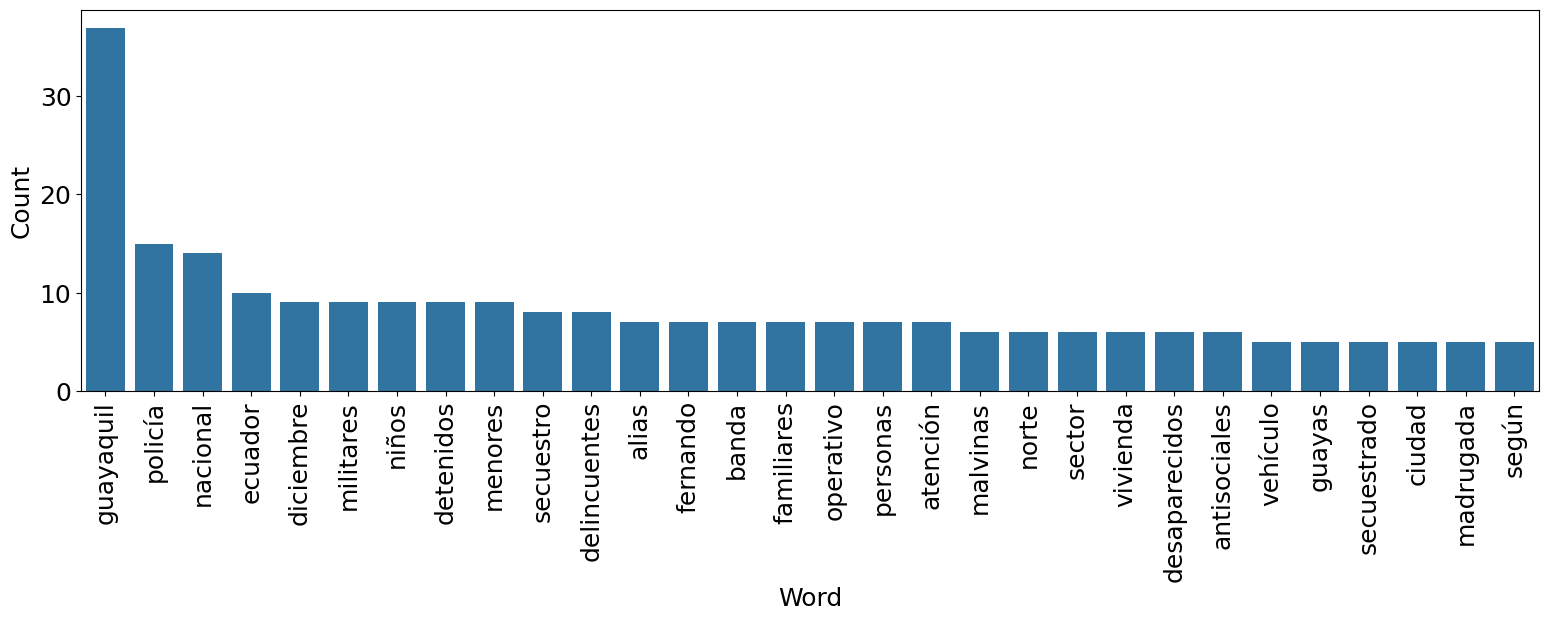

Total rows: 110
Total words: 11627
Words of 5698 False dict_keys(['quieren', 'menores', 'vendan', 'droga', 'meterlos', 'bandas', 'vinieron', 'dañar', 'reclutar', 'cambiar', 'leyes', 'poner', 'escuadrón', 'delinsi', 'sector', 'cuchacho', 'viviaen', 'vicente', 'rocafuerte', 'estudiante', 'muertos', 'venta', 'guerra', 'territoriodanielnoboaoky', 'presidente', 'cuestion', 'seguridad', 'estamosque', 'impotenciaasi', 'entero', 'joven', 'mataron', 'colegio', 'estudia', 'mismo', 'sicariato', 'suburbioun', 'menor', 'futuro', 'delincuente', 'juvenil', 'cadena', 'perpetua', 'adelantetiene', 'aprobar', 'jajajaja', 'montalvo', 'dijopero', 'correa', 'angelitos', 'dónde', 'jueces', 'corruptos', 'liberarmas', 'asambleistas', 'capturados', 'rc5cortea', 'libertad', 'delictivas', 'pertenece', 'latin', 'kingahora', 'publican', 'verdad', 'trabajan', 'autoridades', 'salieron', 'bendiciones', 'ustedes', 'señores', 'policíasdónde', 'presos', 'salen', 'misma', 'correistask', 'pasolos', 'capturan', 'siguen', 'c

C:\Users\emman\AppData\Local\Temp\ipykernel_2212\491521333.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90)


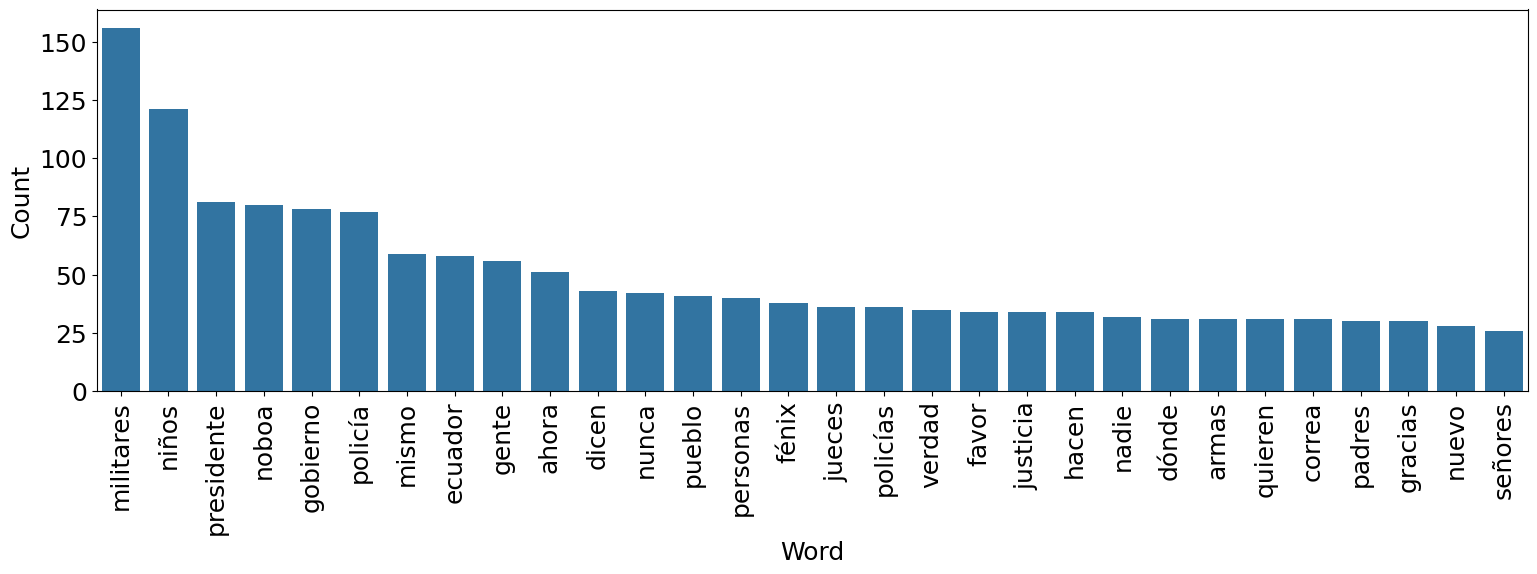

In [166]:
min_length_word = 4
num_bar = 30
"""
Rangos/Picos:
1: 2022-09 -> 2022-11
2: 2023-01 -> 2023-03
3: 2023-05 -> 2023-09
4: 2023-11 -> 2024-01
5: 2024-01 (Fito mi primo)
6: 2024-03 -> 2024-04
7: 2024-06 -> 2024-08
8: 2024-11 -> 2024-12
"""
print_plot(df_tk, ["2022-09", "2022-10", "2022-11"], min_length_word, num_bar)
# print_plot(df_tk, ["2023-01", "2023-02", "2023-03"], min_length_word, num_bar)
# print_plot(df_tk, ["2023-05", "2023-06", "2023-07"], min_length_word, num_bar)
# print_plot(df_tk, ["2023-07", "2023-08", "2023-09"], min_length_word, num_bar)
# print_plot(df_tk, ["2023-11", "2023-12"], min_length_word, num_bar)
print_plot(df_tk, ["2024-01"], min_length_word, num_bar)
print_plot(df_tk, ["2024-03", "2024-04"], min_length_word, num_bar)
print_plot(df_tk, ["2024-06", "2024-07", "2024-08"], min_length_word, num_bar)
print_plot(df_tk, ["2024-11", "2024-12"], min_length_word, num_bar)

In [34]:
# Set display options to show all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

# Simply print the first few rows of the dataframe
print(df.head().to_string())

                                                                      link                                                                                                                                                                                                                                                                                                                                                                                                  description               username       date links  comments shares                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [35]:
# Split the comments_text by "|" and explode the list into separate rows
df_exploded = df.assign(comment=df["comments_text"].str.split("|")).explode("comment")

# Drop the original comments_text column as it's no longer needed
df_exploded = df_exploded.drop(columns=["comments_text"])

# Reset the index for the new DataFrame
df_exploded = df_exploded.reset_index(drop=True)

print(df_exploded.head().to_string())

                                                                    link description             username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                              comment
0  https://www.tiktok.com/@acontecer.noticioso/video/7444203737092017464              acontecer.noticioso 2025-01-10    70       6.0      4                  5    2025-01                 True                                  fenix noboa incapaz
1  https://www.tiktok.com/@acontecer.noticioso/video/7444203737092017464              acontecer.noticioso 2025-01-10    70       6.0      4                  5    2025-01                 True                                                    🥺
2  https://www.tiktok.com/@acontecer.noticioso/video/7444203737092017464              acontecer.noticioso 2025-01-10    70       6.0      4                  5    2025-01                 True                                                    😁
3  https://www.tiktok.co

In [ ]:
from pysentimiento.preprocessing import preprocess_tweet

# Apply preprocessing to both 'comment' and 'description' columns in df_exploded
df_exploded['processed_comment'] = df_exploded['comment'].apply(lambda x: preprocess_tweet(
    str(x),
    shorten=2,  # Shorten repeated characters
    lang="es",  # Spanish language
))

df_exploded['processed_description'] = df_exploded['description'].apply(lambda x: preprocess_tweet(
    str(x),
    shorten=2,  # Shorten repeated characters
    lang="es",  # Spanish language
))

# Print a few examples of original vs processed text
print("Original vs Processed Text:")
pd.set_option('display.max_colwidth', None)
print(df_exploded[['comment', 'processed_comment', 'description', 'processed_description']].head().to_string())

Original vs Processed Comments:
                                               comment                                    processed_comment
0                                  fenix noboa incapaz                                  fenix noboa incapaz
1                                                    🥺                          emoji cara suplicante emoji
2                                                    😁        emoji cara radiante con ojos sonrientes emoji
3                                                    😂                    emoji cara llorando de risa emoji
4  el cuerpo policial desprestigiado. espíritu cuerpo.  el cuerpo policial desprestigiado. espíritu cuerpo.


In [ ]:
# Create figure with two rows for wordcloud and histogram
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Process description text
description_text = ' '.join(df_exploded['processed_description'].astype(str))
comment_text = ' '.join(df_exploded['processed_comment'].astype(str))

# Create word frequency dictionaries
desc_words = {}
comment_words = {}

# Count words for description
for word in description_text.split():
    if word not in stop_words and len(word) > min_length_word:
        desc_words[word] = desc_words.get(word, 0) + 1

# Count words for comments
for word in comment_text.split():
    if word not in stop_words and len(word) > min_length_word:
        comment_words[word] = comment_words.get(word, 0) + 1

# Generate wordclouds
desc_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(desc_words)
comment_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(comment_words)

# Plot wordclouds
ax1.imshow(desc_wordcloud, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Description Wordcloud')

ax2.imshow(comment_wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Comments Wordcloud')

# Create DataFrames for plotting histograms
desc_df = pd.DataFrame(list(desc_words.items()), columns=['word', 'count'])
comment_df = pd.DataFrame(list(comment_words.items()), columns=['word', 'count'])

# Sort by count and get top words
desc_df = desc_df.sort_values('count', ascending=False).head(num_bar)
comment_df = comment_df.sort_values('count', ascending=False).head(num_bar)

# Plot histograms
sns.barplot(data=desc_df, x='word', y='count', ax=ax3)
ax3.tick_params(axis='x', rotation=90)
ax3.set_title('Top Words in Descriptions')

sns.barplot(data=comment_df, x='word', y='count', ax=ax4)
ax4.tick_params(axis='x', rotation=90)
ax4.set_title('Top Words in Comments')

plt.tight_layout()
plt.show()

In [ ]:
# Create lists for sectors and genres
sectors = ['norte', 'sur', 'centro']
genres = ['hombre', 'mujer']  # We'll handle plural forms in the counting logic

# Create dictionaries for counts
sector_desc = {sector: 0 for sector in sectors}
sector_comm = {sector: 0 for sector in sectors}
genre_desc = {genre: 0 for genre in genres}
genre_comm = {genre: 0 for genre in genres}

# Count mentions in descriptions and comments
for sector in sectors:
    sector_desc[sector] = df_exploded[df_exploded['processed_description'].str.contains(sector, case=False, na=False)].shape[0]
    sector_comm[sector] = df_exploded[df_exploded['processed_comment'].str.contains(sector, case=False, na=False)].shape[0]

# Count mentions for genres (including plural forms)
genre_desc['mujer'] = df_exploded[df_exploded['processed_description'].str.contains('mujer|mujeres', case=False, na=False, regex=True)].shape[0]
genre_desc['hombre'] = df_exploded[df_exploded['processed_description'].str.contains('hombre|hombres', case=False, na=False, regex=True)].shape[0]
genre_comm['mujer'] = df_exploded[df_exploded['processed_comment'].str.contains('mujer|mujeres', case=False, na=False, regex=True)].shape[0]
genre_comm['hombre'] = df_exploded[df_exploded['processed_comment'].str.contains('hombre|hombres', case=False, na=False, regex=True)].shape[0]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot sectors
x = range(len(sectors))
width = 0.35

# Create bars with different colors and hatching patterns
bars1 = ax1.bar([i - width/2 for i in x], [sector_desc[sector] for sector in sectors], width, 
                label='Descriptions', color='skyblue', edgecolor='black', hatch='x')
bars2 = ax1.bar([i + width/2 for i in x], [sector_comm[sector] for sector in sectors], width, 
                label='Comments', color='lightcoral', edgecolor='black', hatch='o')

ax1.set_ylabel('Count')
ax1.set_title('Mentions by Sector')
ax1.set_xticks(x)
ax1.set_xticklabels(sectors)
ax1.legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

# Plot genres with different colors and hatching patterns
x = range(len(genres))
bars3 = ax2.bar([i - width/2 for i in x], [genre_desc[genre] for genre in genres], width, 
                label='Descriptions', color='skyblue', edgecolor='black', hatch='x')
bars4 = ax2.bar([i + width/2 for i in x], [genre_comm[genre] for genre in genres], width, 
                label='Comments', color='lightcoral', edgecolor='black', hatch='o')

ax2.set_ylabel('Count')
ax2.set_title('Mentions by Genre')
ax2.set_xticks(x)
ax2.set_xticklabels(genres)
ax2.legend()

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [24]:
# exclusive
peak_words = [
    ["policía", "policías"],  # OR
    ["militares"],  # OR
    ["delincuentes", "antisociales", "criminales"],  # OR
    "detenidos",
    "banda",
    ["presidente", "noboa", "daniel", "fénix", "gobierno"],  # OR
    "sicarios",
    "jueces",
    "correa",
    "asambleístas",
]

In [57]:
# Fix peak_words definition to correctly handle 'correa'
peak_words = [
    ["policía", "policías"],  # OR
    ["militares"],  # OR
    ["delincuentes", "antisociales", "criminales"],  # OR
    "detenidos",
    "banda",
    ["presidente", "noboa", "daniel", "fénix", "gobierno"],  # OR
    "sicarios",
    "jueces",
    "venezolano",
    "correa",  # Changed from 'venezolanocorrea' to just 'correa'
    "asambleístas",
]

# Map to store peak word group names
peak_word_groups = {
    0: "policia",
    1: "militares",
    2: "delincuentes",
    3: "detenidos",
    4: "banda",
    5: "gobierno",
    6: "sicarios",
    7: "jueces",
    8: "venezolano",
    9: "correa",
    10: "asambleistas",
}


def contains_peak_words(text, peak_words):
    matches = []
    if pd.isna(text) or text == "":
        return matches

    for i, group in enumerate(peak_words):
        if isinstance(group, list):
            if any(word.lower() in text.lower() for word in group):
                matches.append(i)
        else:
            if group.lower() in text.lower():
                matches.append(i)
    return matches if matches else []


# Analyze description and comments separately
df_exploded["description_matches"] = df_exploded["description"].apply(
    lambda x: contains_peak_words(str(x), peak_words)
)
df_exploded["comment_matches"] = df_exploded["processed_comment"].apply(
    lambda x: contains_peak_words(str(x), peak_words)
)

# Create boolean columns for each group in descriptions
for group_id, group_name in peak_word_groups.items():
    df_exploded[f"desc_{group_name}"] = df_exploded["description_matches"].apply(
        lambda x: group_id in x
    )
    df_exploded[f"comment_{group_name}"] = df_exploded["comment_matches"].apply(
        lambda x: group_id in x
    )

# Calculate stats for descriptions and comments separately
desc_stats = {}
comment_stats = {}

for group_id, group_name in peak_word_groups.items():
    desc_count = df_exploded[f"desc_{group_name}"].sum()
    comment_count = df_exploded[f"comment_{group_name}"].sum()
    desc_stats[group_name] = desc_count
    comment_stats[group_name] = comment_count

# Print summary
print("\nDescription Peak Word Statistics:")
for group_name, count in desc_stats.items():
    print(f"{group_name}: {count} matches")

print("\nComment Peak Word Statistics:")
for group_name, count in comment_stats.items():
    print(f"{group_name}: {count} matches")

# Calculate overlap between description and comments
overlap_stats = {}
for group_name in peak_word_groups.values():
    overlap = df_exploded[
        df_exploded[f"desc_{group_name}"] & df_exploded[f"comment_{group_name}"]
    ].shape[0]
    overlap_stats[group_name] = overlap

print("\nOverlap Statistics (words appearing in both description and comments):")
for group_name, count in overlap_stats.items():
    print(f"{group_name}: {count} overlaps")


Description Peak Word Statistics:
policia: 1668 matches
militares: 692 matches
delincuentes: 1435 matches
detenidos: 810 matches
banda: 990 matches
gobierno: 796 matches
sicarios: 480 matches
jueces: 0 matches
venezolano: 73 matches
correa: 0 matches
asambleistas: 0 matches

Comment Peak Word Statistics:
policia: 839 matches
militares: 530 matches
delincuentes: 172 matches
detenidos: 45 matches
banda: 199 matches
gobierno: 1901 matches
sicarios: 5 matches
jueces: 360 matches
venezolano: 11 matches
correa: 216 matches
asambleistas: 57 matches

Overlap Statistics (words appearing in both description and comments):
policia: 143 overlaps
militares: 141 overlaps
delincuentes: 13 overlaps
detenidos: 9 overlaps
banda: 33 overlaps
gobierno: 180 overlaps
sicarios: 0 overlaps
jueces: 0 overlaps
venezolano: 0 overlaps
correa: 0 overlaps
asambleistas: 0 overlaps


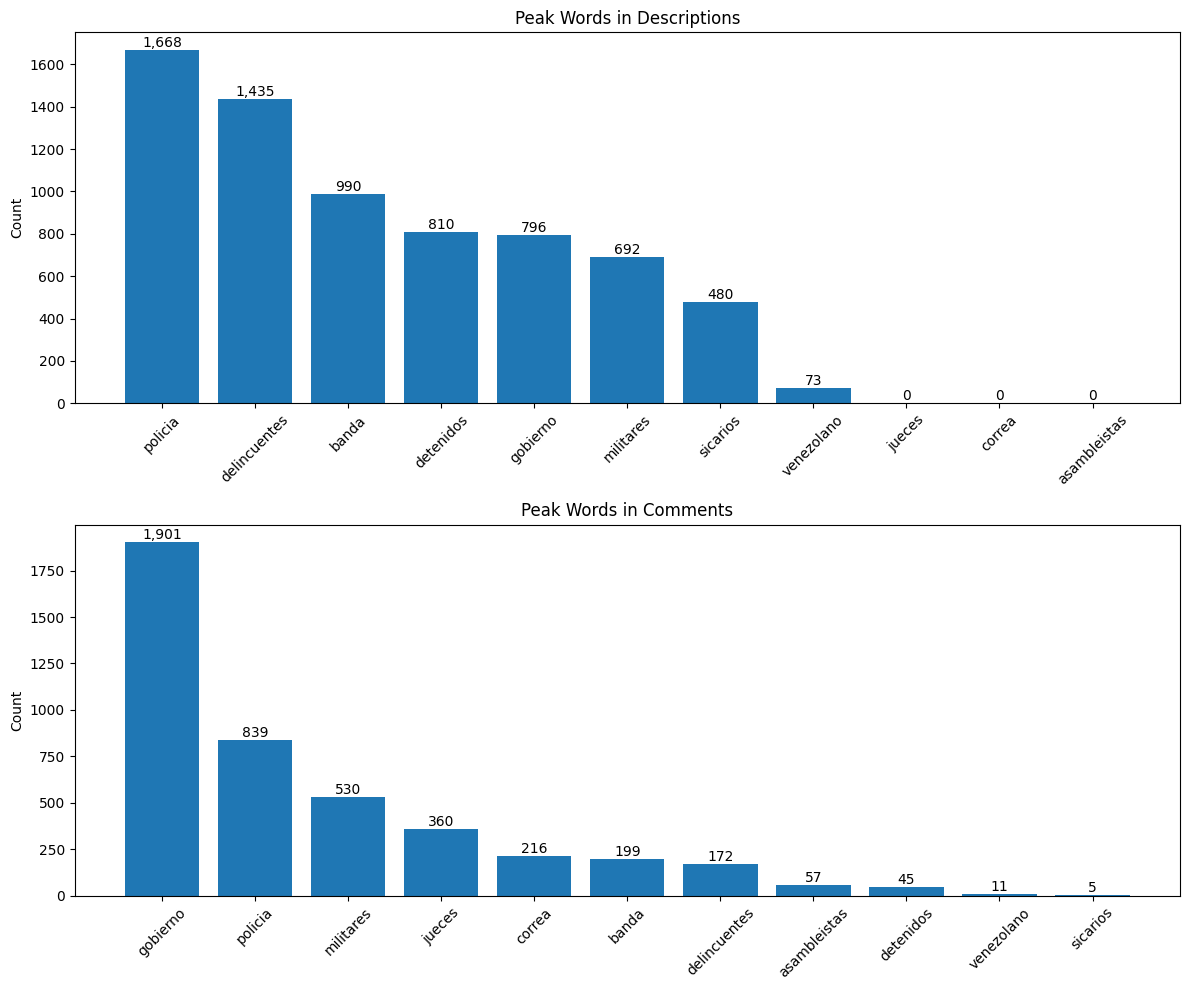

In [62]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Sort the data by count for better visualization
desc_items = sorted(desc_stats.items(), key=lambda x: x[1], reverse=True)
comment_items = sorted(comment_stats.items(), key=lambda x: x[1], reverse=True)

# Plot description statistics
desc_words = [item[0] for item in desc_items]
desc_counts = [item[1] for item in desc_items]
bars1 = ax1.bar(desc_words, desc_counts)
ax1.set_title("Peak Words in Descriptions")
ax1.set_ylabel("Count")
ax1.tick_params(axis="x", rotation=45)

# Plot comment statistics
comment_words = [item[0] for item in comment_items]
comment_counts = [item[1] for item in comment_items]
bars2 = ax2.bar(comment_words, comment_counts)
ax2.set_title("Peak Words in Comments")
ax2.set_ylabel("Count")
ax2.tick_params(axis="x", rotation=45)


# Add value labels on top of each bar
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{int(height):,}",
            ha="center",
            va="bottom",
        )


add_value_labels(ax1, bars1)
add_value_labels(ax2, bars2)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [72]:
import time
import pandas as pd
import torch
from pysentimiento import create_analyzer

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create a hate speech analyzer for Spanish language
hate_speech_analyzer = create_analyzer(task="hate_speech", lang="es", device=device)


# Function to analyze hate speech in text
def analyze_hate_speech(text):
    if pd.isna(text) or text == "":
        return {"output": [], "hateful": None, "targeted": None, "aggressive": None}
    result = hate_speech_analyzer.predict(text)
    return {
        "output": result.output,
        "hateful": result.probas["hateful"],
        "targeted": result.probas["targeted"],
        "aggressive": result.probas["aggressive"],
    }


# Function to process a batch of data
def process_batch(df_batch):
    df_batch["description_hate_speech"] = df_batch.apply(
        lambda row: (
            row["description_hate_speech"]
            if isinstance(row["description_hate_speech"], dict)
            and row["description_hate_speech"]["output"]
            else analyze_hate_speech(str(row["description"]))
        ),
        axis=1,
    )
    df_batch["comment_hate_speech"] = df_batch.apply(
        lambda row: (
            row["comment_hate_speech"]
            if isinstance(row["comment_hate_speech"], dict)
            and row["comment_hate_speech"]["output"]
            else analyze_hate_speech(str(row["processed_comment"]))
        ),
        axis=1,
    )
    return df_batch


# Filter the dataset to include only rows with matches
df_matches = df_exploded[
    (
        df_exploded["description"].apply(
            lambda x: any(
                word in str(x).lower()
                for group in peak_words
                for word in (group if isinstance(group, list) else [group])
            )
        )
    )
    | (
        df_exploded["processed_comment"].apply(
            lambda x: any(
                word in str(x).lower()
                for group in peak_words
                for word in (group if isinstance(group, list) else [group])
            )
        )
    )
]

# Initialize columns if they don't exist
if "description_hate_speech" not in df_exploded.columns:
    df_exploded["description_hate_speech"] = None
if "comment_hate_speech" not in df_exploded.columns:
    df_exploded["comment_hate_speech"] = None

# Split the filtered dataset into batches
batch_size = 100  # Adjust the batch size as needed
num_batches = len(df_matches) // batch_size + 1

# Process each batch and measure the time taken
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df_matches))
    df_batch = df_matches.iloc[start_idx:end_idx]

    start_time = time.time()
    df_batch = process_batch(df_batch)
    end_time = time.time()

    elapsed_time = end_time - start_time
    print(f"Time taken for batch {i + 1}/{num_batches}: {elapsed_time:.2f} seconds")

    # Calculate the number and proportion of records with non-empty output
    description_with_output = (
        df_batch["description_hate_speech"].apply(lambda x: bool(x["output"])).sum()
    )
    comment_with_output = (
        df_batch["comment_hate_speech"].apply(lambda x: bool(x["output"])).sum()
    )
    total_records = len(df_batch)
    total_with_output = description_with_output + comment_with_output
    proportion_with_output = total_with_output / (2 * total_records)
    print(
        f"Batch {i + 1}: {total_with_output} records with non-empty output, proportion: {proportion_with_output:.2f}"
    )

    # Calculate the number of unique descriptions and comments with non-empty output
    unique_descriptions_with_output = df_batch[
        df_batch["description_hate_speech"].apply(lambda x: bool(x["output"]))
    ]["description"].nunique()
    unique_comments_with_output = df_batch[
        df_batch["comment_hate_speech"].apply(lambda x: bool(x["output"]))
    ]["processed_comment"].nunique()
    print(
        f"Batch {i + 1}: {unique_descriptions_with_output} unique descriptions with non-empty output, {unique_comments_with_output} unique comments with non-empty output"
    )

    # Filter and print only the records with non-empty output
    df_with_output = df_batch[
        (df_batch["description_hate_speech"].apply(lambda x: bool(x["output"])))
        | (df_batch["comment_hate_speech"].apply(lambda x: bool(x["output"])))
    ]
    if not df_with_output.empty:
        print(df_with_output.head().to_string())

    # Update the main DataFrame with the processed batch
    df_matches.iloc[start_idx:end_idx] = df_batch

# Example of accessing the results
print(df_matches[["description_hate_speech", "comment_hate_speech"]].head().to_string())

Using device: cpu


C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 1/79: 26.65 seconds
Batch 1: 7 records with non-empty output, proportion: 0.04
Batch 1: 0 unique descriptions with non-empty output, 7 unique comments with non-empty output
                                                                        link                                                                                                                                                                               description               username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                             comment                                                                                                   processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_a

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 2/79: 23.62 seconds
Batch 2: 3 records with non-empty output, proportion: 0.01
Batch 2: 0 unique descriptions with non-empty output, 3 unique comments with non-empty output
                                                                          link                                                                                                                                             description                 username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                             comment                                                                                   processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matche

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 3/79: 21.12 seconds
Batch 3: 5 records with non-empty output, proportion: 0.03
Batch 3: 0 unique descriptions with non-empty output, 5 unique comments with non-empty output
                                                                 link                                                                               description username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                       comment                                                                                                             processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  d

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 4/79: 15.96 seconds
Batch 4: 33 records with non-empty output, proportion: 0.17
Batch 4: 1 unique descriptions with non-empty output, 2 unique comments with non-empty output
                                                                     link                                                                                                                      description username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                comment                                                 processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delincuentes  comment_delincuentes  desc_detenid

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 5/79: 25.02 seconds
Batch 5: 0 records with non-empty output, proportion: 0.00
Batch 5: 0 unique descriptions with non-empty output, 0 unique comments with non-empty output


C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 6/79: 19.75 seconds
Batch 6: 7 records with non-empty output, proportion: 0.04
Batch 6: 0 unique descriptions with non-empty output, 7 unique comments with non-empty output
                                                                    link                                                                                                          description username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                         comment                                                                       processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 7/79: 20.51 seconds
Batch 7: 6 records with non-empty output, proportion: 0.03
Batch 7: 0 unique descriptions with non-empty output, 6 unique comments with non-empty output
                                                                   link                                                                                                                                                                                                  description username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                           comment                                                 processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 8/79: 20.89 seconds
Batch 8: 3 records with non-empty output, proportion: 0.01
Batch 8: 0 unique descriptions with non-empty output, 3 unique comments with non-empty output
                                                                 link                                                                                                                                                                                                                                                                                    description username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                        comment                                                              processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  conta

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 9/79: 17.66 seconds
Batch 9: 14 records with non-empty output, proportion: 0.07
Batch 9: 1 unique descriptions with non-empty output, 4 unique comments with non-empty output
                                                                         link                           description username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                               comment                                     processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delincuentes  comment_delincuentes  desc_detenidos  comment_detenidos  desc_banda  comment_banda  desc_gobierno  comment_gobierno  desc_sicarios  co

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 10/79: 21.02 seconds
Batch 10: 1 records with non-empty output, proportion: 0.01
Batch 10: 0 unique descriptions with non-empty output, 1 unique comments with non-empty output
                                                                     link                                                                                                                                                                                                                                                                           description           username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                       comment                                             processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contain

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 11/79: 19.59 seconds
Batch 11: 8 records with non-empty output, proportion: 0.04
Batch 11: 0 unique descriptions with non-empty output, 8 unique comments with non-empty output
                                                                    link                                                                                                                                                                                      description          username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                                    comment                                                                                                                          processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  c

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 12/79: 23.00 seconds
Batch 12: 0 records with non-empty output, proportion: 0.00
Batch 12: 0 unique descriptions with non-empty output, 0 unique comments with non-empty output


C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 13/79: 20.98 seconds
Batch 13: 2 records with non-empty output, proportion: 0.01
Batch 13: 0 unique descriptions with non-empty output, 2 unique comments with non-empty output
                                                                    link                                                                                                                                                                                     description          username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                            comment                                                                                                  processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asa

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 14/79: 21.97 seconds
Batch 14: 4 records with non-empty output, proportion: 0.02
Batch 14: 0 unique descriptions with non-empty output, 4 unique comments with non-empty output
                                                                         link                                                                                                                                                                                                                                                                                              description               username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                         comment                                                                                          processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobiern

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 15/79: 20.27 seconds
Batch 15: 3 records with non-empty output, proportion: 0.01
Batch 15: 0 unique descriptions with non-empty output, 3 unique comments with non-empty output
                                                                 link                                                                                                         description       username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                   comment                                         processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delincuentes  comment_delincuentes  desc_detenidos  comment_de

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 16/79: 15.63 seconds
Batch 16: 1 records with non-empty output, proportion: 0.01
Batch 16: 0 unique descriptions with non-empty output, 1 unique comments with non-empty output
                                                                    link                                                                description          username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                       comment                                                             processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delincuentes  comment_delincuentes  desc_detenidos  comm

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 17/79: 12.41 seconds
Batch 17: 2 records with non-empty output, proportion: 0.01
Batch 17: 0 unique descriptions with non-empty output, 2 unique comments with non-empty output
                                                                     link                                                                                description           username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                      comment                                                            processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delincuentes  comment_delincuentes  desc_

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 18/79: 16.04 seconds
Batch 18: 5 records with non-empty output, proportion: 0.03
Batch 18: 0 unique descriptions with non-empty output, 5 unique comments with non-empty output
                                                                     link                                                                                                                                                                  description           username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                         comment                                                                  processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 19/79: 16.66 seconds
Batch 19: 2 records with non-empty output, proportion: 0.01
Batch 19: 0 unique descriptions with non-empty output, 2 unique comments with non-empty output
                                                                    link                                                                                                                                                                                                                                                                                                                    description          username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                               comment                                                     processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_juece

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 20/79: 15.73 seconds
Batch 20: 3 records with non-empty output, proportion: 0.01
Batch 20: 0 unique descriptions with non-empty output, 3 unique comments with non-empty output
                                                                    link                                                                                                                                                                                                                                                                                                                    description          username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                   comment                                                         processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contai

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 21/79: 12.53 seconds
Batch 21: 5 records with non-empty output, proportion: 0.03
Batch 21: 0 unique descriptions with non-empty output, 5 unique comments with non-empty output
                                                                          link                                  description                username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                        comment                                                                                              processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delincue

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 22/79: 19.40 seconds
Batch 22: 4 records with non-empty output, proportion: 0.02
Batch 22: 0 unique descriptions with non-empty output, 4 unique comments with non-empty output
                                                                         link                                                                                                                                                                                                           description               username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                                      comment                                                                                                                                                                      processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 23/79: 15.91 seconds
Batch 23: 8 records with non-empty output, proportion: 0.04
Batch 23: 0 unique descriptions with non-empty output, 8 unique comments with non-empty output
                                                                      link                                                                                                                                                                                                                                         description            username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                                                                comment                                                                                                                                                                                                processed_comment pe

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 24/79: 14.91 seconds
Batch 24: 4 records with non-empty output, proportion: 0.02
Batch 24: 0 unique descriptions with non-empty output, 4 unique comments with non-empty output
                                                                           link                                                                                                                                                                                                                                                                                      description                 username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                          comment                                                                processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contain

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 25/79: 15.05 seconds
Batch 25: 0 records with non-empty output, proportion: 0.00
Batch 25: 0 unique descriptions with non-empty output, 0 unique comments with non-empty output


C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 26/79: 19.77 seconds
Batch 26: 4 records with non-empty output, proportion: 0.02
Batch 26: 0 unique descriptions with non-empty output, 4 unique comments with non-empty output
                                                                         link                                                                                                                                                                                                                                                                                                                                                                                                               description               username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                      comment                                                                            processed_comment peak_word_matches  c

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 27/79: 20.22 seconds
Batch 27: 6 records with non-empty output, proportion: 0.03
Batch 27: 0 unique descriptions with non-empty output, 6 unique comments with non-empty output
                                                                         link                                                                                              description               username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                        comment                                                                              processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 28/79: 19.58 seconds
Batch 28: 5 records with non-empty output, proportion: 0.03
Batch 28: 0 unique descriptions with non-empty output, 5 unique comments with non-empty output
                                                                         link                                                                                                                                                                                                              description               username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                    comment                                                                                                                                                     processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_b

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 29/79: 19.37 seconds
Batch 29: 5 records with non-empty output, proportion: 0.03
Batch 29: 0 unique descriptions with non-empty output, 5 unique comments with non-empty output
                                                                 link                                                                                                                                                                                                    description       username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                    comment                                                                             processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 30/79: 19.14 seconds
Batch 30: 7 records with non-empty output, proportion: 0.04
Batch 30: 1 unique descriptions with non-empty output, 5 unique comments with non-empty output
                                                                    link                                                                                                                                                                                                description          username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                comment                      processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delinc

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 31/79: 12.77 seconds
Batch 31: 4 records with non-empty output, proportion: 0.02
Batch 31: 0 unique descriptions with non-empty output, 4 unique comments with non-empty output
                                                                 link                                                                                                                                      description       username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                             comment                                                                                                   processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comme

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 32/79: 17.25 seconds
Batch 32: 11 records with non-empty output, proportion: 0.06
Batch 32: 0 unique descriptions with non-empty output, 11 unique comments with non-empty output
                                                                      link                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  description            username       date   links  comments shares  scrapped_comments month-year  contains_peak_words                               

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 33/79: 11.44 seconds
Batch 33: 4 records with non-empty output, proportion: 0.02
Batch 33: 0 unique descriptions with non-empty output, 4 unique comments with non-empty output
                                                                  link                                                             description        username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                       comment                                                             processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delincuentes  comment_delincuentes  desc_detenidos  comment_det

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 34/79: 12.83 seconds
Batch 34: 3 records with non-empty output, proportion: 0.01
Batch 34: 0 unique descriptions with non-empty output, 3 unique comments with non-empty output
                                                                    link                                                                                                    description          username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                     comment                                                           processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delincuentes  comment_de

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 35/79: 14.69 seconds
Batch 35: 1 records with non-empty output, proportion: 0.01
Batch 35: 0 unique descriptions with non-empty output, 1 unique comments with non-empty output
                                                                  link                                                                    description username       date links  comments shares  scrapped_comments month-year  contains_peak_words                              comment                    processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delincuentes  comment_delincuentes  desc_detenidos  comment_detenidos  desc_banda  comment_banda  desc_gobierno  comment_gobierno  desc_sicarios  

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 36/79: 16.83 seconds
Batch 36: 2 records with non-empty output, proportion: 0.01
Batch 36: 0 unique descriptions with non-empty output, 2 unique comments with non-empty output
                                                                  link                                                                                                                                                                                                                                                                                                 description username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                         comment                               processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 37/79: 14.31 seconds
Batch 37: 0 records with non-empty output, proportion: 0.00
Batch 37: 0 unique descriptions with non-empty output, 0 unique comments with non-empty output


C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 38/79: 14.16 seconds
Batch 38: 2 records with non-empty output, proportion: 0.01
Batch 38: 0 unique descriptions with non-empty output, 2 unique comments with non-empty output
                                                                     link                                                                                description username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                         comment                                               processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delincuentes  comment_delincuentes  desc_detenidos  comment_detenidos  desc_b

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 39/79: 16.14 seconds
Batch 39: 2 records with non-empty output, proportion: 0.01
Batch 39: 0 unique descriptions with non-empty output, 2 unique comments with non-empty output
                                                                    link                                                                                 description username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                                                                comment                                                                                                                                                                                                processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_juece

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 40/79: 13.45 seconds
Batch 40: 1 records with non-empty output, proportion: 0.01
Batch 40: 0 unique descriptions with non-empty output, 1 unique comments with non-empty output
                                                              link       description username       date links  comments shares  scrapped_comments month-year  contains_peak_words                          comment            processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delincuentes  comment_delincuentes  desc_detenidos  comment_detenidos  desc_banda  comment_banda  desc_gobierno  comment_gobierno  desc_sicarios  comment_sicarios  desc_jueces  comment_jueces  desc_correa  comment_correa  d

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 41/79: 14.98 seconds
Batch 41: 7 records with non-empty output, proportion: 0.04
Batch 41: 0 unique descriptions with non-empty output, 7 unique comments with non-empty output
                                                                  link                                                                                                                                                   description    username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                        comment                                                                              processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comme

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 42/79: 17.28 seconds
Batch 42: 8 records with non-empty output, proportion: 0.04
Batch 42: 0 unique descriptions with non-empty output, 8 unique comments with non-empty output
                                                                          link                                                                                                                                          description               username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                                                                                                                                                   comment                                                                                                                                                                                                                         

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 43/79: 19.38 seconds
Batch 43: 2 records with non-empty output, proportion: 0.01
Batch 43: 0 unique descriptions with non-empty output, 2 unique comments with non-empty output
                                                                   link                                                                                                                                          description        username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                              comment                                                                                                                                                       processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 44/79: 16.00 seconds
Batch 44: 4 records with non-empty output, proportion: 0.02
Batch 44: 0 unique descriptions with non-empty output, 4 unique comments with non-empty output
                                                                 link                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 45/79: 20.54 seconds
Batch 45: 9 records with non-empty output, proportion: 0.04
Batch 45: 0 unique descriptions with non-empty output, 9 unique comments with non-empty output
                                                                   link                                                                      description        username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                          comment                                                                                                processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 46/79: 22.74 seconds
Batch 46: 7 records with non-empty output, proportion: 0.04
Batch 46: 0 unique descriptions with non-empty output, 7 unique comments with non-empty output
                                                                      link                                                                                                                                                                                                                           description           username       date   links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                              comment                                                                                                    processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  cont

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 47/79: 22.76 seconds
Batch 47: 17 records with non-empty output, proportion: 0.09
Batch 47: 0 unique descriptions with non-empty output, 17 unique comments with non-empty output
                                                                link                                                                                                                                                                                                                                                                                                             description     username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                                                                                                                                                                                                                                   

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 48/79: 26.02 seconds
Batch 48: 6 records with non-empty output, proportion: 0.03
Batch 48: 0 unique descriptions with non-empty output, 6 unique comments with non-empty output
                                                                     link                                                                                                      description          username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                          comment                                                                processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delincuente

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 49/79: 28.28 seconds
Batch 49: 9 records with non-empty output, proportion: 0.04
Batch 49: 0 unique descriptions with non-empty output, 9 unique comments with non-empty output
                                                              link                                                            description   username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                    comment                                                          processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delincuentes  comment_delincuentes  desc_detenidos  comment_detenidos  desc_band

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 50/79: 21.05 seconds
Batch 50: 10 records with non-empty output, proportion: 0.05
Batch 50: 1 unique descriptions with non-empty output, 6 unique comments with non-empty output
                                                                   link                                                                                                                                                                                                                                      description        username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                            comment                                                                                                                    processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 51/79: 27.10 seconds
Batch 51: 5 records with non-empty output, proportion: 0.03
Batch 51: 0 unique descriptions with non-empty output, 5 unique comments with non-empty output
                                                                     link                                                                                                                                                                                                                            description          username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                   comment                                                                                                                                    processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 52/79: 29.00 seconds
Batch 52: 6 records with non-empty output, proportion: 0.03
Batch 52: 0 unique descriptions with non-empty output, 6 unique comments with non-empty output
                                                                          link                                                                                                          description               username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                         comment                                                               processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 53/79: 22.72 seconds
Batch 53: 11 records with non-empty output, proportion: 0.06
Batch 53: 1 unique descriptions with non-empty output, 7 unique comments with non-empty output
                                                                          link                                                                                                                                                                                                                                                                                                                                                            description               username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                    comment                                                        processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 54/79: 21.19 seconds
Batch 54: 5 records with non-empty output, proportion: 0.03
Batch 54: 0 unique descriptions with non-empty output, 5 unique comments with non-empty output
                                                                        link                               description             username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                  comment                                                                                                                  processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_de

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 55/79: 17.74 seconds
Batch 55: 5 records with non-empty output, proportion: 0.03
Batch 55: 0 unique descriptions with non-empty output, 5 unique comments with non-empty output
                                                                          link                                                                                                                                                                                                  description               username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                             comment                                                                                                                                                                                                                                   processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 56/79: 12.86 seconds
Batch 56: 6 records with non-empty output, proportion: 0.03
Batch 56: 1 unique descriptions with non-empty output, 4 unique comments with non-empty output
                                                                      link                                                                                                                                                                   description           username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                                                                comment                                                                                                                                                                                                processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincu

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 57/79: 31.40 seconds
Batch 57: 5 records with non-empty output, proportion: 0.03
Batch 57: 0 unique descriptions with non-empty output, 5 unique comments with non-empty output
                                                                      link                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 58/79: 24.35 seconds
Batch 58: 3 records with non-empty output, proportion: 0.01
Batch 58: 0 unique descriptions with non-empty output, 3 unique comments with non-empty output
                                                                   link                                                                                                           description        username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                comment                                                                     processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 59/79: 17.42 seconds
Batch 59: 7 records with non-empty output, proportion: 0.04
Batch 59: 0 unique descriptions with non-empty output, 7 unique comments with non-empty output
                                                                      link                                                                                                                                                                                          description           username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                         comment                                                                                               processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_a

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 60/79: 15.74 seconds
Batch 60: 5 records with non-empty output, proportion: 0.03
Batch 60: 0 unique descriptions with non-empty output, 5 unique comments with non-empty output
                                                                      link                                                                                          description           username       date   links  comments shares  scrapped_comments month-year  contains_peak_words                                                                    comment                                                          processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delincuentes  comment_delincuent

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 61/79: 21.11 seconds
Batch 61: 6 records with non-empty output, proportion: 0.03
Batch 61: 0 unique descriptions with non-empty output, 6 unique comments with non-empty output
                                                                      link                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      description           username       date  links  comments shares  

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 62/79: 25.32 seconds
Batch 62: 1 records with non-empty output, proportion: 0.01
Batch 62: 0 unique descriptions with non-empty output, 1 unique comments with non-empty output
                                                            link                                                                                                                                                                                                                                                                                                                                                                                 description username       date links  comments shares  scrapped_comments month-year  contains_peak_words                               comment                     processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezola

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 63/79: 18.41 seconds
Batch 63: 2 records with non-empty output, proportion: 0.01
Batch 63: 0 unique descriptions with non-empty output, 2 unique comments with non-empty output
                                                                     link                                                        description          username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                         comment                                                               processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delincuentes  comment_delincuentes  desc_detenidos  comment_

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 64/79: 14.83 seconds
Batch 64: 3 records with non-empty output, proportion: 0.01
Batch 64: 0 unique descriptions with non-empty output, 3 unique comments with non-empty output
                                                                    link                                                                                                                                            description         username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                                                                                                           comment                                                                                                                                                                                                 processed_comment peak_word_matches  contains_policia  contains_militares 

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 65/79: 17.83 seconds
Batch 65: 2 records with non-empty output, proportion: 0.01
Batch 65: 0 unique descriptions with non-empty output, 2 unique comments with non-empty output
                                                                       link                                                                                                                                                                                               description            username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                       comment                                                                                                             processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_juec

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 66/79: 17.31 seconds
Batch 66: 5 records with non-empty output, proportion: 0.03
Batch 66: 0 unique descriptions with non-empty output, 5 unique comments with non-empty output
                                                                    link                                                                                                                                    description         username       date   links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                       comment                                                                                                          processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 67/79: 16.49 seconds
Batch 67: 9 records with non-empty output, proportion: 0.04
Batch 67: 0 unique descriptions with non-empty output, 9 unique comments with non-empty output
                                                                     link                                                                                                          description          username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                             comment                                                                                                                                                                                                                                                                                                                                                                                                                          

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 68/79: 18.92 seconds
Batch 68: 3 records with non-empty output, proportion: 0.01
Batch 68: 0 unique descriptions with non-empty output, 3 unique comments with non-empty output
                                                                          link                                                                                                                                                                                                                                                      description               username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                                                                comment                                                                                                                                                                                                

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 69/79: 15.92 seconds
Batch 69: 16 records with non-empty output, proportion: 0.08
Batch 69: 1 unique descriptions with non-empty output, 3 unique comments with non-empty output
                                                                  link                                                                                                                                                              description       username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                    comment                                                                                                          processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  c

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 70/79: 16.28 seconds
Batch 70: 3 records with non-empty output, proportion: 0.01
Batch 70: 0 unique descriptions with non-empty output, 3 unique comments with non-empty output
                                                                           link                    description                username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                                                                comment                                                                                                                                                                                                processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asamb

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 71/79: 14.91 seconds
Batch 71: 9 records with non-empty output, proportion: 0.04
Batch 71: 0 unique descriptions with non-empty output, 9 unique comments with non-empty output
                                                               link                                                                                                                description    username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                       comment                                                                             processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_mili

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 72/79: 15.41 seconds
Batch 72: 26 records with non-empty output, proportion: 0.13
Batch 72: 2 unique descriptions with non-empty output, 7 unique comments with non-empty output
                                                                       link                                                                                                       description            username       date   links  comments shares  scrapped_comments month-year  contains_peak_words                                                                            comment                                                            processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delinc

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 73/79: 17.82 seconds
Batch 73: 7 records with non-empty output, proportion: 0.04
Batch 73: 0 unique descriptions with non-empty output, 7 unique comments with non-empty output
                                                                       link                                                                                                                                                                                                                                    description            username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                        comment                                                              processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_c

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 74/79: 21.02 seconds
Batch 74: 3 records with non-empty output, proportion: 0.01
Batch 74: 0 unique descriptions with non-empty output, 3 unique comments with non-empty output
                                                                  link                                                                                                                                                                                        description       username       date   links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                               comment                                                                                                                    processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_juece

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 75/79: 14.71 seconds
Batch 75: 7 records with non-empty output, proportion: 0.04
Batch 75: 0 unique descriptions with non-empty output, 7 unique comments with non-empty output
                                                                link                                                        description     username       date   links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                         comment                                                                                                              processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militare

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 76/79: 16.52 seconds
Batch 76: 3 records with non-empty output, proportion: 0.01
Batch 76: 0 unique descriptions with non-empty output, 3 unique comments with non-empty output
                                                                          link                                                                                                                                                                                                                                     description               username       date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                          comment                                                                                                                processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  co

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 77/79: 15.21 seconds
Batch 77: 1 records with non-empty output, proportion: 0.01
Batch 77: 0 unique descriptions with non-empty output, 1 unique comments with non-empty output
                                                                     link                                                                         description          username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                   comment                                                         processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa description_matches comment_matches  desc_policia  comment_policia  desc_militares  comment_militares  desc_delincuentes  comment_delincuentes  desc_detenidos  co

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


Time taken for batch 78/79: 14.37 seconds
Batch 78: 5 records with non-empty output, proportion: 0.03
Batch 78: 0 unique descriptions with non-empty output, 5 unique comments with non-empty output
                                                                  link                                                                                                                                                                                                         description       username       date  links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                      comment                                                                            processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sicarios  contains_jueces  contains_venezolano  contains_asambleistas  contains_correa de

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['description_hate_speech'] = df_batch.apply(


Time taken for batch 79/79: 8.74 seconds
Batch 79: 0 records with non-empty output, proportion: 0.00
Batch 79: 0 unique descriptions with non-empty output, 0 unique comments with non-empty output
                                                                                                  description_hate_speech                                                                                                   comment_hate_speech
0                                                   {'output': [], 'hateful': None, 'targeted': None, 'aggressive': None}   {'output': [], 'hateful': 0.025066902860999107, 'targeted': 0.021861691027879715, 'aggressive': 0.0238732248544693}
7   {'output': [], 'hateful': 0.024858610704541206, 'targeted': 0.007138221990317106, 'aggressive': 0.013044244609773159}   {'output': [], 'hateful': 0.10170818865299225, 'targeted': 0.008892308920621872, 'aggressive': 0.04315681383013725}
10  {'output': [], 'hateful': 0.024858610704541206, 'targeted': 0.007138221990317106

C:\Users\lenovo\AppData\Local\Temp\ipykernel_33144\108636704.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch['comment_hate_speech'] = df_batch.apply(


In [111]:
import csv
import pandas as pd

df_matches = pd.read_csv(
    "processed_hate_speech_analysis.csv",
    quoting=csv.QUOTE_ALL,  # Quote all fields
    escapechar="\\",  # Use backslash as escape character
    encoding="utf-8",  # UTF-8 encoding for Spanish text
    na_values=["", "nan"],  # Handle empty values
    dtype={
        "description": str,
        "processed_comment": str,
        "description_hate_speech": str,
        "comment_hate_speech": str,
    },
)

# Convert string representations of dictionaries back to dictionaries
df_matches["description_hate_speech"] = df_matches["description_hate_speech"].apply(
    eval
)
df_matches["comment_hate_speech"] = df_matches["comment_hate_speech"].apply(eval)

# Verify loading
print(f"Loaded {len(df_matches)} rows")
print("\nSample data:")
print(df_matches.head().to_string())

Loaded 7850 rows

Sample data:
                                                                    link                                                                                                                                                                                                                                                                                                                                                                                                  description             username        date links  comments shares  scrapped_comments month-year  contains_peak_words                                                                                                                   comment                                                                                                         processed_comment peak_word_matches  contains_policia  contains_militares  contains_delincuentes  contains_detenidos  contains_banda  contains_gobierno  contains_sica

In [99]:
import numpy as np

In [100]:
def get_dominant_category(hate_speech_dict):
    """
    Returns dominant hate speech category from analyzer output
    Input format example:
    {
        'output': [...],
        'hateful': 0.2,
        'targeted': 0.5,
        'aggressive': 0.3
    }
    """
    # Handle null/empty cases
    if not hate_speech_dict or not isinstance(hate_speech_dict, dict):
        return "none"

    # Define categories to check
    categories = ["hateful", "targeted", "aggressive"]

    try:
        # Check if we have direct probability values
        if all(cat in hate_speech_dict for cat in categories):
            scores = [hate_speech_dict[cat] for cat in categories]
        # Check if probabilities are nested under 'probas'
        elif "probas" in hate_speech_dict:
            scores = [hate_speech_dict["probas"][cat] for cat in categories]
        else:
            return "none"

        # Get category with highest probability
        max_index = scores.index(max(scores))
        return categories[max_index]

    except (KeyError, TypeError):
        return "none"


DEBUG - Data Counts:
-------------------

Description Data:

policia:
hateful: 71
targeted: 0
aggressive: 0

militares:
hateful: 18
targeted: 0
aggressive: 0

delincuentes:
hateful: 53
targeted: 0
aggressive: 0

detenidos:
hateful: 31
targeted: 1
aggressive: 0

banda:
hateful: 36
targeted: 0
aggressive: 0

gobierno:
hateful: 31
targeted: 0
aggressive: 0

sicarios:
hateful: 19
targeted: 0
aggressive: 0

jueces:
hateful: 0
targeted: 0
aggressive: 0

venezolano:
hateful: 4
targeted: 0
aggressive: 0

correa:
hateful: 0
targeted: 0
aggressive: 0

asambleistas:
hateful: 0
targeted: 0
aggressive: 0

Comment Data:

policia:
hateful: 833
targeted: 3
aggressive: 3

militares:
hateful: 526
targeted: 2
aggressive: 2

delincuentes:
hateful: 169
targeted: 0
aggressive: 3

detenidos:
hateful: 43
targeted: 2
aggressive: 0

banda:
hateful: 194
targeted: 5
aggressive: 0

gobierno:
hateful: 1796
targeted: 73
aggressive: 32

sicarios:
hateful: 5
targeted: 0
aggressive: 0

jueces:
hateful: 359
targeted: 0

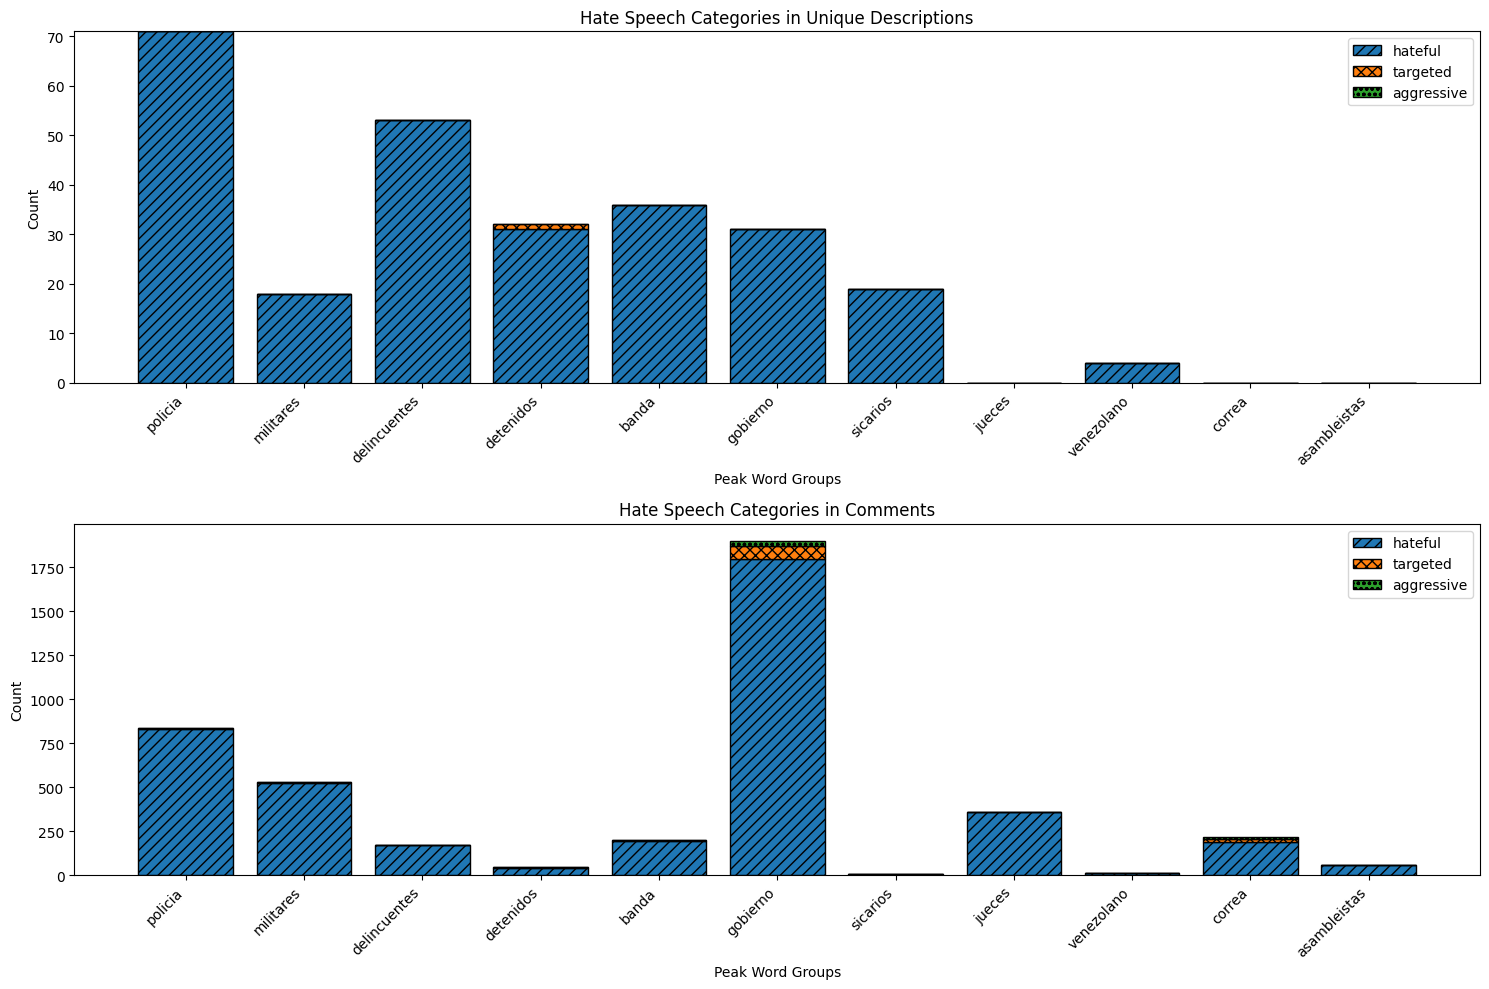

In [120]:
def plot_hate_speech_analysis(df):
    categories = ["hateful", "targeted", "aggressive"]
    groups = list(peak_word_groups.values())
    hatches = ["///", "xxx", "ooo"]  # Distinct patterns for each category

    # Initialize arrays
    desc_data = np.zeros((len(groups), len(categories)))
    comment_data = np.zeros((len(groups), len(categories)))

    # Get unique descriptions
    unique_desc_df = df.drop_duplicates(subset=["description"])

    print("\nDEBUG - Data Counts:")
    print("-------------------")

    # Count and print description data
    print("\nDescription Data:")
    for i, group_name in peak_word_groups.items():
        desc_matches = unique_desc_df[f"desc_{group_name}"]
        print(f"\n{group_name}:")
        for idx, cat in enumerate(categories):
            count = sum(
                get_dominant_category(row["description_hate_speech"]) == cat
                for _, row in unique_desc_df[desc_matches].iterrows()
            )
            desc_data[i][idx] = count
            print(f"{cat}: {count}")

    # Count and print comment data
    print("\nComment Data:")
    for i, group_name in peak_word_groups.items():
        comment_matches = df[f"comment_{group_name}"]
        print(f"\n{group_name}:")
        for idx, cat in enumerate(categories):
            count = sum(
                get_dominant_category(row["comment_hate_speech"]) == cat
                for _, row in df[comment_matches].iterrows()
            )
            comment_data[i][idx] = count
            print(f"{cat}: {count}")

    print("\nShape of arrays:")
    print(f"desc_data shape: {desc_data.shape}")
    print(f"comment_data shape: {comment_data.shape}")

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot descriptions with hatching
    bottom = np.zeros(len(groups))
    bars1 = []
    for idx, category in enumerate(categories):
        bars = ax1.bar(
            groups,
            desc_data[:, idx],
            bottom=bottom,
            label=category,
            hatch=hatches[idx],
            edgecolor="black",
            linewidth=1,
        )
        bars1.append(bars)
        bottom += desc_data[:, idx]

    # Plot comments with hatching
    bottom = np.zeros(len(groups))
    bars2 = []
    for idx, category in enumerate(categories):
        bars = ax2.bar(
            groups,
            comment_data[:, idx],
            bottom=bottom,
            label=category,
            hatch=hatches[idx],
            edgecolor="black",
            linewidth=1,
        )
        bars2.append(bars)
        bottom += comment_data[:, idx]

    ax1.set_title("Hate Speech Categories in Unique Descriptions")
    ax2.set_title("Hate Speech Categories in Comments")

    for ax in [ax1, ax2]:
        ax.legend()
        ax.set_xlabel("Peak Word Groups")
        ax.set_ylabel("Count")
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    return fig


# Generate and display plot
fig = plot_hate_speech_analysis(df_matches)
plt.show()


DEBUG - Data Counts:
-------------------

Description Data:

policia:
targeted: 0
aggressive: 0

militares:
targeted: 0
aggressive: 0

delincuentes:
targeted: 0
aggressive: 0

detenidos:
targeted: 1
aggressive: 0

banda:
targeted: 0
aggressive: 0

gobierno:
targeted: 0
aggressive: 0

sicarios:
targeted: 0
aggressive: 0

jueces:
targeted: 0
aggressive: 0

venezolano:
targeted: 0
aggressive: 0

correa:
targeted: 0
aggressive: 0

asambleistas:
targeted: 0
aggressive: 0

Comment Data:

policia:
targeted: 3
aggressive: 3

militares:
targeted: 2
aggressive: 2

delincuentes:
targeted: 0
aggressive: 3

detenidos:
targeted: 2
aggressive: 0

banda:
targeted: 5
aggressive: 0

gobierno:
targeted: 73
aggressive: 32

sicarios:
targeted: 0
aggressive: 0

jueces:
targeted: 0
aggressive: 1

venezolano:
targeted: 0
aggressive: 0

correa:
targeted: 14
aggressive: 13

asambleistas:
targeted: 0
aggressive: 1


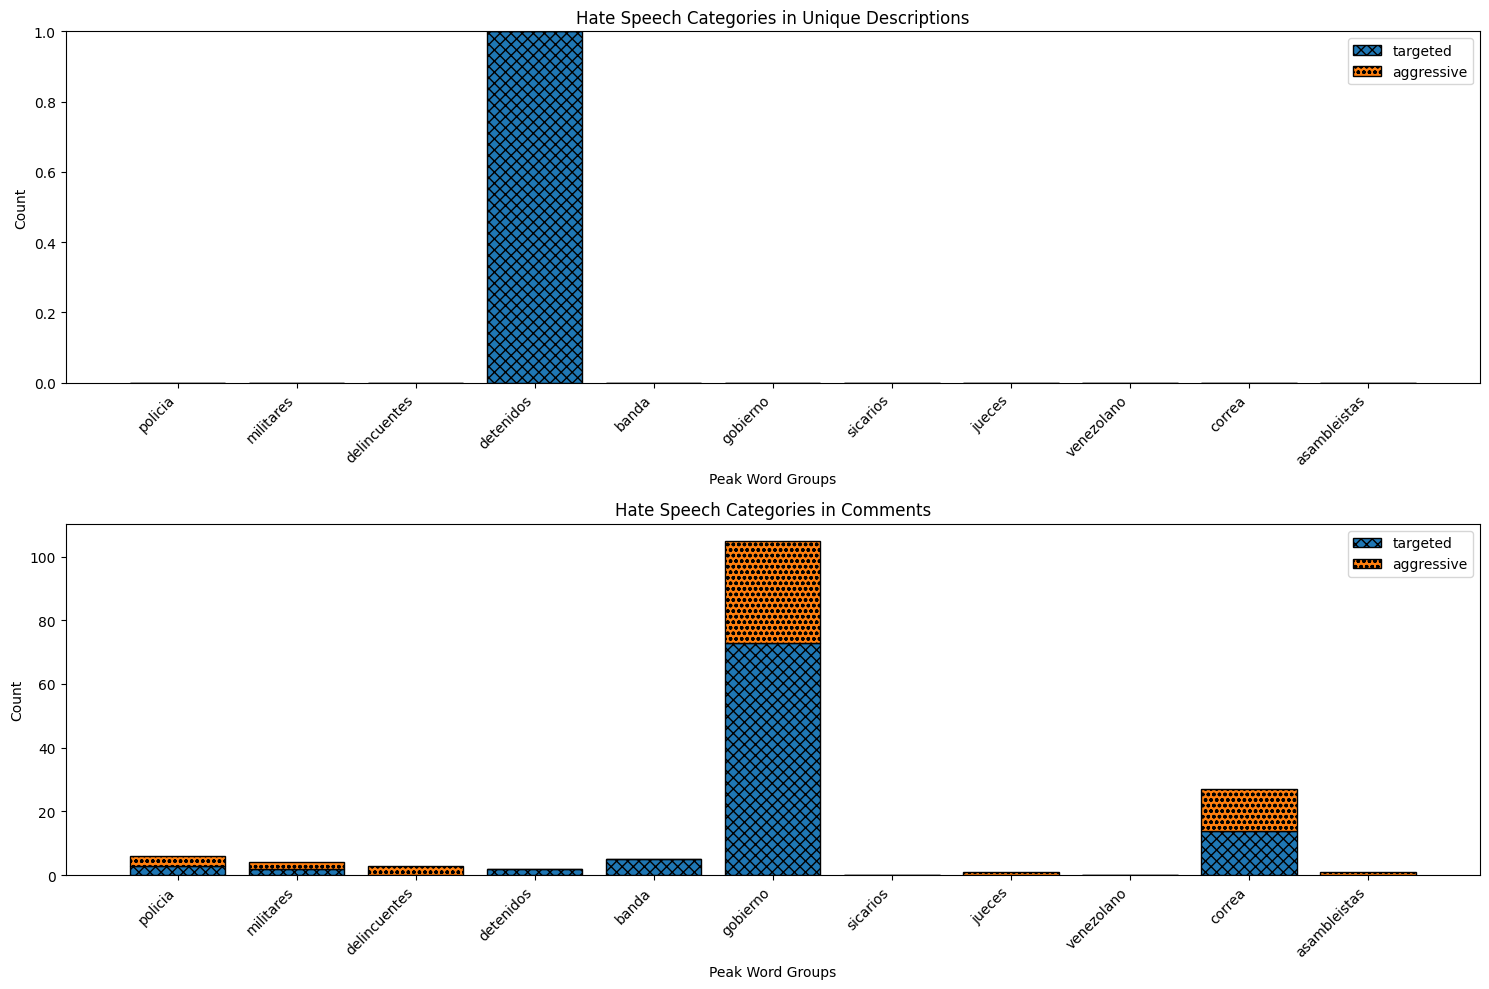

In [121]:
def plot_hate_speech_analysis(df):
    categories = ["targeted", "aggressive"]
    groups = list(peak_word_groups.values())
    hatches = ["xxx", "ooo"]  # Updated patterns for two categories

    # Initialize arrays
    desc_data = np.zeros((len(groups), len(categories)))
    comment_data = np.zeros((len(groups), len(categories)))

    # Get unique descriptions
    unique_desc_df = df.drop_duplicates(subset=["description"])

    print("\nDEBUG - Data Counts:")
    print("-------------------")

    # Count description data
    print("\nDescription Data:")
    for i, group_name in peak_word_groups.items():
        desc_matches = unique_desc_df[f"desc_{group_name}"]
        print(f"\n{group_name}:")
        for idx, cat in enumerate(categories):
            count = sum(
                get_dominant_category(row["description_hate_speech"]) == cat
                for _, row in unique_desc_df[desc_matches].iterrows()
            )
            desc_data[i][idx] = count
            print(f"{cat}: {count}")

    # Count comment data
    print("\nComment Data:")
    for i, group_name in peak_word_groups.items():
        comment_matches = df[f"comment_{group_name}"]
        print(f"\n{group_name}:")
        for idx, cat in enumerate(categories):
            count = sum(
                get_dominant_category(row["comment_hate_speech"]) == cat
                for _, row in df[comment_matches].iterrows()
            )
            comment_data[i][idx] = count
            print(f"{cat}: {count}")

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot descriptions with hatching
    bottom = np.zeros(len(groups))
    bars1 = []
    for idx, category in enumerate(categories):
        bars = ax1.bar(
            groups,
            desc_data[:, idx],
            bottom=bottom,
            label=category,
            hatch=hatches[idx],
            edgecolor="black",
            linewidth=1,
        )
        bars1.append(bars)
        bottom += desc_data[:, idx]

    # Plot comments with hatching
    bottom = np.zeros(len(groups))
    bars2 = []
    for idx, category in enumerate(categories):
        bars = ax2.bar(
            groups,
            comment_data[:, idx],
            bottom=bottom,
            label=category,
            hatch=hatches[idx],
            edgecolor="black",
            linewidth=1,
        )
        bars2.append(bars)
        bottom += comment_data[:, idx]

    ax1.set_title("Hate Speech Categories in Unique Descriptions")
    ax2.set_title("Hate Speech Categories in Comments")

    for ax in [ax1, ax2]:
        ax.legend()
        ax.set_xlabel("Peak Word Groups")
        ax.set_ylabel("Count")
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    return fig


# Generate and display plot
fig = plot_hate_speech_analysis(df_matches)
plt.show()